<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Example Implementation of GRHayL: Replicating the IllinoisGRMHD code using GRHayL

## Author: Terrence Pierre Jacques
### Formatting improvements courtesy Brandon Clark

## This notebook will utilize the General Relativistic Hydrodynamic Library (GRHayL) to recreate the results of the IllinoisGRMHD code, for a suite of GRMHD shock tests.

**Notebook Status:** <font color ="red"><b> Not validated </b></font>

<!-- **Validation Notes:** This module has been validated to converge at the expected order to the exact solution (see [plot](#convergence) at bottom). -->

<!-- ### NRPy+ Source Code for this module: 
* [ScalarWave/ScalarWaveCurvilinear_RHSs.py](../edit/ScalarWave/ScalarWaveCurvilinear_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWaveCurvilinear.ipynb) Generates the right-hand side for the Scalar Wave Equation in curvilinear coordinates
* [ScalarWave/InitialData.py](../edit/ScalarWave/InitialData.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) Generating C code for either plane wave or spherical Gaussian initial data for the scalar wave equation  -->

## Introduction:
GRHayL is code base that aims to provide robust and well tested codes for evolving relativistic fluids. Towards this end, GRHayL currently supports reconstruction, flux/source term calculations, hybrid and tabulated equations of state, and conservative-to-primitive solvers

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>GRMHD RHS expressions.</font>
    1. Apply conservatives-to-primitives routines
    1. Apply boundary conditions.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#writec): Generate C code to solve the scalar wave equation in curvilinear coordinates
    1. [Step 1.a](#id_rhss): C code generation: Initial data and scalar wave right-hand-sides
    1. [Step 1.b](#OuterBoundaryConditions): C code generation: Boundary condition driver
    1. [Step 1.c](#cparams_rfm_and_domainsize): Generate Cparameters files; set reference metric parameters, including `domain_size`
    1. [Step 1.d](#cfl): C code generation: Finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
1. [Step 2](#mainc): The C code `main()` function for `ScalarWaveCurvilinear_Playground`
1. [Step 3](#compileexec): Compile generated C codes & solve the scalar wave equation
1. [Step 4](#convergence): Code validation: Plot the numerical error, and confirm that it converges to zero at expected rate with increasing numerical resolution (sampling)
1. [Step 5](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='writec'></a>

# Step 1: Using NRPy+ to generate necessary C codes to supplement codes in GRHayL to solve the equations of GRMHD \[Back to [top](#toc)\]
$$\label{writec}$$

<a id='id_rhss'></a>

## Step 1.a: C code generation: Initial data and GRMHD RHSs \[Back to [top](#toc)\]
$$\label{id_rhss}$$

To evolve the GRMHD equations in time, we need to specify initial data, that we may march forward using the method of lines approach (MoL), and right-hand-sides (RHSs) to dictate how these data are evolved. 

We begin by importing some key NRPy+ python modules. We then construct C codes to supply initial data to our grid functions. These initial data are 1D and 2D shock tests, and all options are compiled so that at run time we may choose which initial data set we wish to evolve test. The tests ar stored in the ShockTests directory within NRPy+.

In [1]:
import shutil, os, sys                # Standard Python modules for multiplatform OS-level functions
nrpy_dir_path = os.path.join("../../GRHayL/Flux_Source/nrpy")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)
    
    # Step P1: Import needed NRPy+ core modules:
from outputC import outputC, lhrh, outCfunction, add_to_Cfunction_dict, outC_function_master_list
# NRPy+: Core C code output module
from pickling import unpickle_NRPy_env  # NRPy+: Pickle/unpickle NRPy+ environment, for parallel codegen
import finite_difference as fin       # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par        # NRPy+: Parameter interface
import grid as gri                    # NRPy+: Functions having to do with numerical grids
import reference_metric as rfm        # NRPy+: Reference metric support
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import cmdline_helper as cmd          # NRPy+: Multi-platform Python command-line interface
import sympy as sp

# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("GRHayL_NRPy_IGH_TOV_BSSN_EVOL_Ccodes")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesrootdir, "output")
cmd.mkdir(outdir)

# Step P4: Enable/disable SIMD. If enabled, code should run ~2x faster on most CPUs.
enable_SIMD = False

# Step P5: Enable reference metric precomputation.
enable_rfm_precompute = False
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "True")
else:
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "False")

# if enable_SIMD and not enable_rfm_precompute:
#     print("ERROR: SIMD does not currently handle transcendental functions,\n")
#     print("       like those found in rfmstruct (rfm_precompute).\n")
#     print("       Therefore, enable_SIMD==True and enable_rfm_precompute==False\n")
#     print("       is not supported.\n")
#     sys.exit(1)

# Step P6: Enable "FD functions". In other words, all finite-difference stencils
#         will be output as inlined static functions. This is essential for
#         compiling highly complex FD kernels with using certain versions of GCC;
#         GCC 10-ish will choke on BSSN FD kernels at high FD order, sometimes
#         taking *hours* to compile. Unaffected GCC versions compile these kernels
#         in seconds. FD functions do not slow the code performance, but do add
#         another header file to the C source tree.
# With gcc 7.5.0, enable_FD_functions=True decreases performance by 10%
enable_FD_functions = False

# Step 1: Set some core parameters, including CoordSystem, boundary condition,
#                                             MoL, timestepping algorithm, FD order,
#                                             floating point precision, and CFL factor:

# Step 1.a: Set the coordinate system for the numerical grid
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Cartesian"
par.set_parval_from_str("reference_metric::CoordSystem", CoordSystem)
rfm.reference_metric()


# Step 1.d: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.
default_CFL_FACTOR= 0.5

outer_bc_type = "RADIATION_OUTER_BCS"  # can be EXTRAPOLATION_OUTER_BCS or RADIATION_OUTER_BCS
radiation_BC_FD_order = 2

# Set the lapse & shift evolution equations to be consistent with the original Hydro without Hydro paper.
# Compile-time (i.e., NRPy+-time) parameters for both Baikal & BaikalVacuum:
LapseCondition = "OnePlusLog"
ShiftCondition = "GammaDriving2ndOrder_NoCovariant"
# enable_golden_kernels = True

# LapseCondition  = "HarmonicSlicing"
# ShiftCondition  = "Frozen"

par.set_parval_from_str("grid::DIM", 3)
DIM = par.parval_from_str("grid::DIM")

In [2]:
# Step 5: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

# Directory for reference_metric precomputation header files:
rfm_precompute_Ccode_outdir = os.path.join(Ccodesrootdir, "rfm_files/")
if enable_rfm_precompute:
    cmd.mkdir(os.path.join(Ccodesrootdir, "rfm_files/"))
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", rfm_precompute_Ccode_outdir)

# Step 6: Copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
if enable_SIMD:
    cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
    shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesrootdir,"SIMD/"))

# Step 7: Set finite_difference::enable_FD_functions appropriately. Defaults to False
if enable_FD_functions:
    par.set_parval_from_str("finite_difference::enable_FD_functions", enable_FD_functions)

# Step 8: If enable_SIMD, then copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
if enable_SIMD:
    shutil.copy(os.path.join("SIMD", "SIMD_intrinsics.h"), os.path.join(Ccodesrootdir, "SIMD"))


In [3]:
alphatmp = gri.register_gridfunctions("AUXEVOL","alphatmp")
betaU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","betaU", DIM=3)
gammaDD = ixp.register_gridfunctions_for_single_rank2("AUXEVOL", "gammaDD", "sym01")
KDD = ixp.register_gridfunctions_for_single_rank2("AUXEVOL", "KDD", "sym01")

alpha_face = gri.register_gridfunctions("AUXEVOL","alpha_face")
beta_faceU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","beta_faceU", DIM=3)
gamma_faceDD = ixp.register_gridfunctions_for_single_rank2("AUXEVOL", "gamma_faceDD", "sym01")

vU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","vU",DIM=3)
vrU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","vrU",DIM=3)
vlU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","vlU",DIM=3)
u4Ut = gri.register_gridfunctions("AUXEVOL","u4Ut")
u4rUt = gri.register_gridfunctions("AUXEVOL","u4rUt")
u4lUt = gri.register_gridfunctions("AUXEVOL","u4lUt")

StildeD = ixp.register_gridfunctions_for_single_rank1("EVOL","StildeD")
rho_star = gri.register_gridfunctions("EVOL","rho_star")
tau_tilde = gri.register_gridfunctions("EVOL","tau_tilde")

Stilde_flux_HLLD = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","Stilde_flux_HLLD")
rho_star_flux_HLL = gri.register_gridfunctions("AUXEVOL","rho_star_flux_HLL")
tau_tilde_flux_HLL = gri.register_gridfunctions("AUXEVOL","tau_tilde_flux_HLL")

rhob = gri.register_gridfunctions("AUXEVOL","rhob")
rhob_r = gri.register_gridfunctions("AUXEVOL","rhob_r")
rhob_l = gri.register_gridfunctions("AUXEVOL","rhob_l")
P = gri.register_gridfunctions("AUXEVOL","P")
P_r = gri.register_gridfunctions("AUXEVOL","P_r")
P_l = gri.register_gridfunctions("AUXEVOL","P_l")


In [4]:
!pip install scipy > /dev/null

In [5]:
import TOV.Polytropic_EOSs as ppeos # NRPy+: Piecewise polytrope equation of state support

############################
# Single polytrope example #
############################
# Set neos = 1 (single polytrope)
neos = 1

# Set rho_poly_tab (not needed for a single polytrope)
rho_poly_tab = []

# Set Gamma_poly_tab
Gamma_poly_tab = [2.0]

# Set K_poly_tab0
K_poly_tab0 = 1. # ZACH NOTES: CHANGED FROM 100.

# Set the eos quantities
eos = ppeos.set_up_EOS_parameters__complete_set_of_input_variables(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0)

# Set initial condition (Pressure computed from central density)
rho_baryon_central  = 0.129285
# rho_baryon_central  = 5.4 #0.109285

import TOV.TOV_Solver as TOV
TOV_Mass, R_Schw_TOV, R_iso_TOV = TOV.TOV_Solver(eos,
                                   outfile=os.path.join(Ccodesrootdir, "TOVdata.txt"),
                                   rho_baryon_central=rho_baryon_central,
                                   verbose = True,
                                   accuracy="high",
                                   integrator_type="default",
                                   no_output_File = False,
                                   return_M_RSchw_and_Riso = True)


# Set defaults for Coordinate system parameters.
# These are perhaps the most commonly adjusted parameters,
# so we enable modifications at this high level.

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
# domain_size = 200.0*R_iso_TOV
domain_size = 2.0*R_iso_TOV

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 1.0 # If SymTP chosen

import TOV.TOV_Ccodegen_library as TOVCL  # NRPy+: TOV C codegen library
TOVCL.add_to_Cfunction_dict_TOV_read_data_file_set_ID_persist(interp_stencil_size=12)
TOVCL.add_to_Cfunction_dict_TOV_ID_function()
TOVCL.add_to_Cfunction_dict_TOV_interpolate_1D()

96472 96472 96472 96472 96472 96472
Just generated a TOV star with
* M        = 1.405030336771419e-01 ,
* R_Schw   = 9.566044579331482e-01 ,
* R_iso    = 8.100085557510011e-01 ,
* M/R_Schw = 1.468768334832085e-01 



In [6]:
def add_to_Cfunction_dict_initial_data_driver():
    
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = """This function sets TOV initial data at a single point xCart[3] = (x,y,z),
outputting to initial_data_struct *restrict initial_data"""
    c_type = "void"
    name = "initial_data"
    params = "griddata_struct *restrict griddata"
    
    preloop=r"""
   
   REAL *restrict auxevol_gfs = griddata->gridfuncs.auxevol_gfs;
   paramstruct *restrict params = &griddata->params;
   REAL * xx[3]; for(int ww=0;ww<3;ww++) xx[ww] = griddata->xx[ww];
    
  ID_persist_struct ID_persist;
  TOV_read_data_file_set_ID_persist("TOVdata.txt", &ID_persist);

  initial_data_reader__convert_ADM_Spherical_to_BSSN(griddata, &ID_persist, TOV_ID_function);
  
#include "./set_Cparameters.h"
 
"""
    
    body  = """  // First set r(=rbar), theta, phi in terms of xCart[3]:
  REAL rbar, rho, rho_baryon, press, M, expnu, exp4phi;
  
""" + outputC(rfm.xxSph[0], "rbar",
             filename='returnstring', params="includebraces=False") + r"""
  TOV_interpolate_1D(rbar, &ID_persist, &rho,&rho_baryon,&press,&M,&expnu,&exp4phi);
 """
    
    press, rho_baryon, rbar, rho, expnu, exp4phi = par.Cparameters("REAL",__name__,
                                      ["press", "rho_baryon", "rbar", "rho", "expnu", "exp4phi"], 
                                      default_vals=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    
    vU = ixp.zerorank1()

    gfs_to_print = [
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","vU0"),rhs=vU[0]),
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","vU1"),rhs=vU[1]),
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","vU2"),rhs=vU[2]),
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","rhob"),rhs=rho_baryon + sp.sympify(1e-12)),
                   lhrh(lhs=gri.gfaccess("auxevol_gfs","P"),rhs=press + sp.sympify(1e-24))
                  ]

    body += fin.FD_outputC("returnstring", gfs_to_print,
                          params="outCverbose=False") #GoldenKernelsEnable=True"
    
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        preloop=preloop,
        body=body,
        enableCparameters=False,
        loopopts="AllPoints,Read_xxs")

    # remove C parameters
    _=par.glb_Cparams_list.pop()
    _=par.glb_Cparams_list.pop()
    _=par.glb_Cparams_list.pop()
    _=par.glb_Cparams_list.pop()
    _=par.glb_Cparams_list.pop()
    _=par.glb_Cparams_list.pop()
    _=par.glb_Cparams_list.pop()


<a id='ccodegen'></a>

# Step 3: Generate C code kernels for BSSN expressions, in parallel if possible \[Back to [top](#toc)\]
$$\label{ccodegen}$$

In the following code cell, we create a list of Python functions, which each registers a single C code function in `outputC`'s `outC_function_dict` dictionary. These Python functions are defined in 

1. [`BSSN.Initial_Data_Reader__BSSN_Converter`](../edit/BSSN.Initial_Data_Reader__BSSN_Converter.py); ([\[**tutorial**\]](Tutorial-ADM_Initial_Data_Reader__BSSN_Converter.ipynb)), which registers the C function for our "universal" initial data reader/converter `initial_data_reader__convert_ADM_spherical_to_BSSN()`.
    * This function first calls `TOV_ID_function()` to read the initial data from file. Spacetime data are given in terms of ADM quantities, and fluid quantity data are given in terms of the stress-energy tensor. Then the function converts the ADM quantities to BSSN in our desired reference metric, and performs the basis transform on the stress-energy tensor as well.
1. the [`BSSN.BSSN_Ccodegen_library`](../edit/BSSN/BSSN_Ccodegen_library.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-C_codegen_library.ipynb), which contains Python functions for generating C code from symbolic expressions constructed within the following NRPy+ modules/tutorials:
    1. [BSSN/BSSN_constraints](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates
    1. [BSSN/BSSN_RHSs](../edit/BSSN/BSSN_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb): Generates the right-hand sides for the BSSN evolution equations in singular, curvilinear coordinates
    1. [BSSN/BSSN_gauge_RHSs](../edit/BSSN/BSSN_gauge_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb): Generates the right-hand sides for the BSSN gauge evolution equations in singular, curvilinear coordinates
    1. [BSSN/Enforce_Detgammahat_Constraint](../edit/BSSN/Enforce_Detgammahat_Constraint.py); [**tutorial**](Tutorial-BSSN_enforcing_determinant_gammabar_equals_gammahat_constraint.ipynb): Generates symbolic expressions for enforcing the $\det{\bar{\gamma}}=\det{\hat{\gamma}}$ constraint


Next, from within a `multiprocessing` environment, we then call all the Python C-code generation functions in this list in parallel (if `multiprocessing` is supported). This is quite useful, as these functions take several seconds to complete.

Within each `multiprocessing` process, the current NRPy+ environment is cloned, and a new function is registered to the `outC_function_dict` dictionary. Thus when each process completes, it contains a unique NRPy+ environment, with only its function registered. We address this by saving each process' NRPy+ environment and sending it back in a common binary format known as a `pickle`, using NRPy+'s [`pickling`](../edit/pickling.py) module. The environments are combined in an unpickling such that all functions exist within the same `outC_function_dict` dictionary.

To make the current environment fully consistent, we call `reference_metric.py` to register all its associated C functions (stored in globals) and contributions to `NRPy_basic_defines.h`.

In [7]:
# Step 2: Generate C code kernels for BSSN expressions, in parallel if possible;
import BSSN.BSSN_Ccodegen_library as BCL
# Step 2.a: Create a list of functions we wish to evaluate in parallel (if possible)
# Create lists for all functions we wish to register
codegen_funcs = []
codegen_funcs.append(BCL.add_rhs_eval_to_Cfunction_dict)
codegen_funcs.append(BCL.add_Ricci_eval_to_Cfunction_dict)
codegen_funcs.append(BCL.add_BSSN_constraints_to_Cfunction_dict)
codegen_funcs.append(BCL.add_enforce_detgammahat_constraint_to_Cfunction_dict)

import BSSN.ADM_Initial_Data_Reader__BSSN_Converter as IDread
codegen_funcs.append(IDread.add_to_Cfunction_dict_initial_data_reader__convert_ADM_Sph_or_Cart_to_BSSN)

# Step 2.b: Define master functions for parallelization.
#           Note that lambdifying this doesn't work in Python 3
def master_func(arg):
    if codegen_funcs[arg].__name__ == "add_to_Cfunction_dict_initial_data_reader__convert_ADM_Sph_or_Cart_to_BSSN":
        ret = codegen_funcs[arg](addl_includes=None, rel_path_to_Cparams=os.path.join("."),
                                 input_Coord="Spherical", include_T4UU=True)
    else:
        if enable_rfm_precompute:
            # We use rfm_precompute for all BSSN functions:
            par.set_parval_from_str("reference_metric::enable_rfm_precompute", "True")
            rfm.reference_metric()

        if codegen_funcs[arg].__name__ == "add_BSSN_constraints_to_Cfunction_dict":
            ret = codegen_funcs[arg](includes=["NRPy_basic_defines.h"],
                                     enable_stress_energy_source_terms=True,
                                     rel_path_to_Cparams=os.path.join("."), output_H_only=True,
                                     enable_rfm_precompute=enable_rfm_precompute, enable_SIMD=enable_SIMD)
        elif codegen_funcs[arg].__name__ == "add_rhs_eval_to_Cfunction_dict":
            ret = codegen_funcs[arg](includes=["NRPy_basic_defines.h"],
                                     rel_path_to_Cparams=os.path.join("."),
                                     enable_rfm_precompute=enable_rfm_precompute, enable_SIMD=enable_SIMD,
                                     enable_stress_energy_source_terms=True,
                                     LapseCondition=LapseCondition, ShiftCondition=ShiftCondition)
        elif codegen_funcs[arg].__name__ == "add_Ricci_eval_to_Cfunction_dict":
            ret = codegen_funcs[arg](includes=["NRPy_basic_defines.h"],
                                     rel_path_to_Cparams=os.path.join("."),
                                     enable_rfm_precompute=enable_rfm_precompute, enable_SIMD=enable_SIMD)
        elif codegen_funcs[arg].__name__ == "add_enforce_detgammahat_constraint_to_Cfunction_dict":
            ret = codegen_funcs[arg](includes=["NRPy_basic_defines.h"],
                                     rel_path_to_Cparams=os.path.join("."),
                                     enable_rfm_precompute=enable_rfm_precompute)
        else:
            print("ERROR: DID NOT RECOGNIZE FUNCTION " + codegen_funcs[arg].__name__ + "\n")
            sys.exit(1)
        if enable_rfm_precompute:
            par.set_parval_from_str("reference_metric::enable_rfm_precompute", "False")
            rfm.ref_metric__hatted_quantities()
    return ret


NRPyEnvVars = []
raised_exception = False
try:
    if os.name == 'nt':
        # It's a mess to get working in Windows, so we don't bother. :/
        #  https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac
        raise Exception("Parallel codegen currently not available in certain environments, e.g., Windows")

    # Step 2.d: Import the multiprocessing module.
    import multiprocessing

    # Step 2.e: Evaluate list of functions in parallel if possible;
    #           otherwise fallback to serial evaluation:
    pool = multiprocessing.Pool()
    NRPyEnvVars.append(pool.map(master_func, range(len(codegen_funcs))))
    pool.terminate()
    pool.join()
except:
    print("FAILED PARALLEL CODEGEN!")
    NRPyEnvVars = [] # Reset, as pickling/unpickling unnecessary for serial codegen (see next line)

    # Steps 2.d-e, alternate: As fallback, evaluate functions in serial.
    #       This will happen on Android and Windows systems
    for i, func in enumerate(codegen_funcs):
        master_func(i)
    raised_exception = True

outCfunc_master_list = outC_function_master_list
if not raised_exception:
    outCfunc_master_list = unpickle_NRPy_env(NRPyEnvVars)
    for el in outCfunc_master_list:
        if el not in outC_function_master_list:  # in case there are duplicate funcs, which can happen
            #                                      if finite_difference_functions = True
            outC_function_master_list += [el]

Generating symbolic expressions for BSSN_RHSs (Cartesian coords)...Generating symbolic expressions for 3-Ricci tensor (Cartesian coords)...Generating symbolic expressions for BSSN constraints (Cartesian coords)...


Generating C code for Enforcing det(gammabar)=det(gammahat) constraint (Cartesian coords)...
Finished generating C code for Enforcing det(gammabar)=det(gammahat) constraint (Cartesian coords) in 0.1 seconds.
Finished generating symbolic expressions for 3-Ricci tensor (Cartesian coords) in 0.6 seconds. Next up: C codegen...
Generating C code for 3-Ricci tensor (FD order=4) (Cartesian coords)...
Finished generating symbolic expressions for BSSN_RHSs (Cartesian coords) in 1.5 seconds. Next up: C codegen...
Generating C code for BSSN_RHSs (FD order=4) (Cartesian coords)...
Finished generating symbolic expressions for BSSN constraints (Cartesian coords) in 1.5 seconds. Next up: C codegen...
Generating C code for BSSN constraints (FD order=4) (Cartesian coords)...
Finished genera

In [8]:
def add_to_Cfunction_dict_compute_T4UU():
    grmhd_exp_dir_path = os.path.join("../../GRHayL/Flux_Source")
    sys.path.append(grmhd_exp_dir_path)

    M_PI  = par.Cparameters("#define",__name__,["M_PI"], "")
    sqrt4pi = par.Cparameters("REAL",__name__,"sqrt4pi","sqrt(4.0*M_PI)")
    
    h = par.Cparameters("REAL",__name__,"h", default_vals=1.0)

    import GRMHD_equations_new_version as GRMHD
    GRMHD.set_up_base_vars(formalism="ADM")
    
    # remove magnetic fields
    GRMHD.BU = ixp.zerorank1()
    
    GRMHD.u4U[0] = u4Ut
    for i in range(3):
        GRMHD.u4U[i+1] = vU[i] * u4Ut

    GRMHD.compute_vU_from_u4U__no_speed_limit(GRMHD.u4U)

    GRMHD.compute_sqrtgammaDET(GRMHD.gammaDD)
    GRMHD.compute_smallb4U(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.u4U, GRMHD.BU, sqrt4pi)
    GRMHD.compute_smallbsquared(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.smallb4U)

    # First compute stress-energy tensor T4UU and T4UD:
    GRMHD.compute_T4UU(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.rho_b,GRMHD.P,GRMHD.h,GRMHD.u4U, GRMHD.smallb4U, GRMHD.smallbsquared)
    GRMHD.compute_T4UD(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.T4UU)

    outCparams = "outCverbose=False,CSE_sorting=canonical,CSE_enable=True"
    desc = "Compute the stress-energy tensor T4UU"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    name = "compute_T4UU"
    
    pre_body_str = fr"""
const int index = IDX3S(i0, i1, i2);
        
primitive_quantities prims;
metric_quantities metric;

initialize_primitives(auxevol_gfs[IDX4ptS(RHOBGF, index)], 
                      auxevol_gfs[IDX4ptS(PGF, index)], 
                      0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
                      auxevol_gfs[IDX4ptS(VU0GF, index)], 
                      auxevol_gfs[IDX4ptS(VU1GF, index)], 
                      auxevol_gfs[IDX4ptS(VU2GF, index)],
                      0.0, /*auxevol_gfs[IDX4ptS(BU0GF, index)],*/
                      0.0, /*auxevol_gfs[IDX4ptS(BU1GF, index)],*/
                      0.0, /*auxevol_gfs[IDX4ptS(BU2GF, index)],*/
                      0.0/0.0,
                      0.0/0.0,
                      0.0/0.0,
                      &prims);

initialize_metric(auxevol_gfs[IDX4ptS(ALPHATMPGF, index)],
                  auxevol_gfs[IDX4ptS(GAMMADD00GF, index)], 
                  auxevol_gfs[IDX4ptS(GAMMADD01GF, index)], 
                  auxevol_gfs[IDX4ptS(GAMMADD02GF, index)],
                  auxevol_gfs[IDX4ptS(GAMMADD11GF, index)], 
                  auxevol_gfs[IDX4ptS(GAMMADD12GF, index)], 
                  auxevol_gfs[IDX4ptS(GAMMADD22GF, index)],
                  auxevol_gfs[IDX4ptS(BETAU0GF, index)], 
                  auxevol_gfs[IDX4ptS(BETAU1GF, index)], 
                  auxevol_gfs[IDX4ptS(BETAU2GF, index)],
                  &metric);

int speed_limited = 0;
limit_v_and_compute_u0(eos,
                       &metric,
                       &prims,
                       &speed_limited);

double h, cs2;

eos->compute_h_and_cs2(eos, &prims, &h, &cs2);

auxevol_gfs[IDX4S(U4UTGF, i0,i1,i2)] = prims.u0;

"""
    body = fin.FD_outputC("returnstring",
                          [lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU00"),rhs=GRMHD.T4UU[0][0]),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU01"),rhs=GRMHD.T4UU[0][1]),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU02"),rhs=GRMHD.T4UU[0][2]),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU03"),rhs=GRMHD.T4UU[0][3]),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU11"),rhs=GRMHD.T4UU[1][1]),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU12"),rhs=GRMHD.T4UU[1][2]),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU13"),rhs=GRMHD.T4UU[1][3]),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU22"),rhs=GRMHD.T4UU[2][2]),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU23"),rhs=GRMHD.T4UU[2][3]),
                           lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU33"),rhs=GRMHD.T4UU[3][3])
                            ],
                          params=outCparams)

    c_type = "void"
    params   ="const paramstruct *restrict params, const eos_parameters *restrict eos,"
    params += "REAL *restrict xx[3], "
    params += "const REAL *restrict in_gfs, REAL *restrict auxevol_gfs"
    loopopts = "AllPoints"
    loopopts += ",Read_xxs"

    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=pre_body_str + body,
        rel_path_to_Cparams=os.path.join("."), loopopts = loopopts)
    
    # remove h from parameter list
    _=par.glb_Cparams_list.pop()


In [9]:
def add_to_Cfunction_dict_prims_to_cons():
    grmhd_exp_dir_path = os.path.join("../../GRHayL/Flux_Source")
    sys.path.append(grmhd_exp_dir_path)

    M_PI  = par.Cparameters("#define",__name__,["M_PI"], "")
    sqrt4pi = par.Cparameters("REAL",__name__,"sqrt4pi","sqrt(4.0*M_PI)")
    
    h = par.Cparameters("REAL",__name__,"h", default_vals=1.0)

    import GRMHD_equations_new_version as GRMHD
    GRMHD.set_up_base_vars(formalism="ADM")
    
    # remove magnetic fields
    GRMHD.BU = ixp.zerorank1()
    
    GRMHD.u4U[0] = u4Ut
    for i in range(3):
        GRMHD.u4U[i+1] = vU[i] * u4Ut

    GRMHD.compute_vU_from_u4U__no_speed_limit(GRMHD.u4U)

    GRMHD.compute_sqrtgammaDET(GRMHD.gammaDD)
    GRMHD.compute_smallb4U(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.u4U, GRMHD.BU, sqrt4pi)
    GRMHD.compute_smallbsquared(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.smallb4U)

    # First compute stress-energy tensor T4UU and T4UD:
    GRMHD.compute_T4UU(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.rho_b,GRMHD.P,GRMHD.h,GRMHD.u4U, GRMHD.smallb4U, GRMHD.smallbsquared)
    GRMHD.compute_T4UD(GRMHD.gammaDD,GRMHD.betaU,GRMHD.alpha, GRMHD.T4UU)

    # Compute conservative variables in terms of primitive variables
    GRMHD.compute_rho_star(GRMHD.alpha, GRMHD.sqrtgammaDET, GRMHD.rho_b,GRMHD.u4U)
    GRMHD.compute_tau_tilde(GRMHD.alpha, GRMHD.sqrtgammaDET, GRMHD.T4UU,GRMHD.rho_star)
    GRMHD.compute_S_tildeD(GRMHD.alpha, GRMHD.sqrtgammaDET, GRMHD.T4UD)

    outCparams = "outCverbose=False,CSE_sorting=canonical,CSE_enable=True"
    desc = "Primitives to Conservatives Routine"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    name = "prims_to_cons"
    
    pre_body_str = fr"""
primitive_quantities prims;
initialize_primitives(auxevol_gfs[IDX4S(RHOBGF, i0, i1, i2)], 
                      auxevol_gfs[IDX4S(PGF, i0, i1, i2)], 
                      0.0/0.0,
                      0.0/0.0,
                      0.0/0.0,
                      0.0/0.0,
                      0.0/0.0,
                      0.0/0.0, 
                      0.0/0.0,
                      0.0/0.0,
                      0.0/0.0,
                      0.0/0.0,
                      &prims);

double h, cs2;

eos->compute_h_and_cs2(eos, &prims, &h, &cs2);
"""
    
    body = fin.FD_outputC("returnstring",
                          [lhrh(lhs=gri.gfaccess("in_gfs","StildeD0"),rhs=GRMHD.S_tildeD[0]),
                           lhrh(lhs=gri.gfaccess("in_gfs","StildeD1"),rhs=GRMHD.S_tildeD[1]),
                           lhrh(lhs=gri.gfaccess("in_gfs","StildeD2"),rhs=GRMHD.S_tildeD[2]),
                           lhrh(lhs=gri.gfaccess("in_gfs","rho_star"),rhs=GRMHD.rho_star),
                           lhrh(lhs=gri.gfaccess("in_gfs","tau_tilde"),rhs=GRMHD.tau_tilde)],
                          params=outCparams)

    c_type = "void"
    params   ="const paramstruct *restrict params, const eos_parameters *restrict eos,"
    params += "REAL *restrict xx[3], "
    params += "const REAL *restrict auxevol_gfs, REAL *restrict in_gfs"
    loopopts = "AllPoints"
    loopopts += ",Read_xxs"

    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=pre_body_str + body,
        rel_path_to_Cparams=os.path.join("."), loopopts = loopopts)
    
    # remove h from parameter list
    _=par.glb_Cparams_list.pop()

In [10]:
def add_to_Cfunction_dict__metric_face_interpolation():
    prefunc = r"""
// Side note: the following values could be used for cell averaged gfs:
//     am2=-1.0/12.0, am1=7.0/12.0, a0=7.0/12.0, a1=-1.0/12.0
// However, since the metric gfs store the grid point values instead of the cell average,
//     the following coefficients should be used:
//     am2 = -1/16, am1 = 9/16, a0 = 9/16, a1 = -1/16
// This will yield the third-order-accurate face values at m-1/2,
//      using values specified at {m-2,m-1,m,m+1}
#define AM2 -0.0625
#define AM1  0.5625
#define A0   0.5625
#define A1  -0.0625
#define COMPUTE_FCVAL(METRICm2,METRICm1,METRIC,METRICp1) (AM2*(METRICm2) + AM1*(METRICm1) + A0*(METRIC) + A1*(METRICp1))

"""

    prefunc += r"""
const int metric_gfs_list[10] = {GAMMADD00GF,
                                 GAMMADD01GF,
                                 GAMMADD02GF,
                                 GAMMADD11GF,
                                 GAMMADD12GF,
                                 GAMMADD22GF,
                                 BETAU0GF,
                                 BETAU1GF,
                                 BETAU2GF,
                                 ALPHATMPGF};

const int metric_gfs_face_list[10] = {GAMMA_FACEDD00GF,
                                      GAMMA_FACEDD01GF,
                                      GAMMA_FACEDD02GF,
                                      GAMMA_FACEDD11GF,
                                      GAMMA_FACEDD12GF,
                                      GAMMA_FACEDD22GF,
                                      BETA_FACEU0GF,
                                      BETA_FACEU1GF,
                                      BETA_FACEU2GF,
                                      ALPHA_FACEGF};

const int num_metric_gfs = 10;

"""

    preloop  ="""    int in_gf,out_gf;
    REAL Qm2,Qm1,Qp0,Qp1;

"""
    body     =r"""    
    const int dirn0 = (flux_dirn == 0);
    const int dirn1 = (flux_dirn == 1);
    const int dirn2 = (flux_dirn == 2);
    
    for(int gf = 0;gf < num_metric_gfs;gf++) {
        in_gf  = metric_gfs_list[gf];
        out_gf = metric_gfs_face_list[gf];
        #pragma omp for
        for (int i2 = 2;i2 < Nxx_plus_2NGHOSTS2-1;i2++) {
            for (int i1 = 2;i1 < Nxx_plus_2NGHOSTS1-1;i1++) {
                for (int i0 = 2;i0 < Nxx_plus_2NGHOSTS0-1;i0++) {
                    Qm2 = auxevol_gfs[IDX4S(in_gf,i0-2*dirn0,i1-2*dirn1,i2-2*dirn2)];
                    Qm1 = auxevol_gfs[IDX4S(in_gf,i0-  dirn0,i1-  dirn1,i2-  dirn2)];
                    Qp0 = auxevol_gfs[IDX4S(in_gf,i0,        i1,        i2        )];
                    Qp1 = auxevol_gfs[IDX4S(in_gf,i0+  dirn0,i1+  dirn1,i2+  dirn2)];
                    auxevol_gfs[IDX4S(out_gf,i0,i1,i2)] = COMPUTE_FCVAL(Qm2,Qm1,Qp0,Qp1);

                }
            }
        }
    }
"""

    desc = "Interpolate metric gridfunctions to cell faces"
    name = "interpolate_metric_gfs_to_cell_faces"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    params   ="const paramstruct *params,REAL *auxevol_gfs,const int flux_dirn"
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        name=name, params=params,
        prefunc = prefunc, preloop = preloop, body=body)

In [11]:
def add_to_Cfunction_dict__reconstruction_loop():

    includes = ["NRPy_basic_defines.h"]

    c_type = "void"
    name = "reconstruction_loop"
    desc = "Reconstruct primitives using PPM algorithm"
    params = r"""
const paramstruct *restrict params,
const int flux_dir,
const eos_parameters *restrict eos,
REAL *auxevol_gfs"""

    body = r"""
  
  // Bounds are determined by the stencil, which requires a ghostzone of at least
  // 3, but upper index includes first ghostzone point (stencil is only 2 on upper end)
  // This limit only applies to the direction of the stencil, hence the == logic below.

  const int xdir = (flux_dir == 0);
  const int ydir = (flux_dir == 1);
  const int zdir = (flux_dir == 2);

  const int imin = 3*xdir;
  const int imax = Nxx_plus_2NGHOSTS0 - 2*xdir;
  const int jmin = 3*ydir;
  const int jmax = Nxx_plus_2NGHOSTS1 - 2*ydir;
  const int kmin = 3*zdir;
  const int kmax = Nxx_plus_2NGHOSTS2 - 2*zdir;
  
  const int num_vars = 3;
  const int V_GFs[3] = {VU0GF, VU1GF, VU2GF};
  const int VR_GFs[3] = {VRU0GF, VRU1GF, VRU2GF};
  const int VL_GFs[3] = {VLU0GF, VLU1GF, VLU2GF};

#pragma omp parallel for
  for(int k=kmin; k<kmax; k++)
    for(int j=jmin; j<jmax; j++)
      for(int i=imin; i<imax; i++) {
        const int index = IDX3S(i, j, k);
        double rho[6], pressure[6], v_flux_dir[6];
        double rhor, rhol, pressr, pressl;
        double var_data[num_vars][6], vars_r[num_vars], vars_l[num_vars];

        for(int ind=0; ind<6; ind++) {
          const int stencil = IDX3S(i+xdir*(ind-3), j+ydir*(ind-3), k+zdir*(ind-3)); // PPM needs indices from -3 to +2
          v_flux_dir[ind] = auxevol_gfs[IDX4ptS(V_GFs[flux_dir], stencil)]; // Could be smaller; doesn't use full stencil
          rho[ind] = auxevol_gfs[IDX4ptS(RHOBGF, stencil)];
          pressure[ind] = auxevol_gfs[IDX4ptS(PGF, stencil)];
          for(int var=0; var<num_vars; var++) {
            var_data[var][ind] = auxevol_gfs[IDX4ptS(V_GFs[var], stencil)];
          }
        }

    // Compute Gamma
    const double Gamma = eos_Gamma_eff(eos, auxevol_gfs[IDX4ptS(RHOBGF, index)], auxevol_gfs[IDX4ptS(PGF, index)]);

    simple_ppm(
      rho, pressure, var_data, num_vars,
      v_flux_dir, Gamma,
      &rhor, &rhol, &pressr, &pressl, vars_r, vars_l);

    auxevol_gfs[IDX4ptS(RHOB_RGF, index)] = rhor;
    auxevol_gfs[IDX4ptS(RHOB_LGF, index)] = rhol;
    auxevol_gfs[IDX4ptS(P_RGF, index)] = pressr;
    auxevol_gfs[IDX4ptS(P_LGF, index)] = pressl;
    for(int var=0; var<num_vars; var++) {
      auxevol_gfs[IDX4ptS(VR_GFs[var], index)] = vars_r[var];
      auxevol_gfs[IDX4ptS(VL_GFs[var], index)] = vars_l[var];
    }
  }
"""

    prefunc = r"""
static double eos_Gamma_eff(const eos_parameters *restrict eos, const double rho_in, const double press_in) {
  double K, Gamma;
  eos->hybrid_get_K_and_Gamma(eos, rho_in, &K, &Gamma);
  const double P_cold = K*pow(rho_in, Gamma);
  return eos->Gamma_th + (Gamma - eos->Gamma_th)*P_cold/press_in;
}

"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        name=name, params=params,
        prefunc = prefunc,
        body=body,
        loopopts = "")

In [12]:
def add_to_Cfunction_dict__grhd_rhs_eval():

    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]

    c_type = "void"
    name = "grhd_rhs_eval"
    desc = "Calculate RHSs of GRHD equations"
    params = r"""
const paramstruct *restrict params,
const eos_parameters *restrict eos,
const REAL *restrict in_gfs, 
REAL *auxevol_gfs,
REAL *restrict rhs_gfs"""

    body = r"""


  // Function pointer to allow for loop over fluxes
  void (*calculate_HLLE_fluxes)(const primitive_quantities *restrict, const primitive_quantities *restrict,
                              const eos_parameters *restrict, const metric_quantities *restrict, 
                              const double, const double, conservative_quantities *restrict);

  void (*calculate_characteristic_speed)(const primitive_quantities *restrict, const primitive_quantities *restrict,
                              const eos_parameters *restrict, const metric_quantities *restrict, double *restrict, double *restrict);

  // Function pointer to allow for loop over directional source terms
  void (*calculate_source_terms)(const primitive_quantities *restrict, const eos_parameters *restrict, const metric_quantities *restrict, 
  const metric_derivatives *restrict, conservative_quantities *restrict);

  // initialize grid functions to 0.0
  const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;  
#pragma omp parallel for
  LOOP_REGION(3, Nxx_plus_2NGHOSTS0-3,
              3, Nxx_plus_2NGHOSTS1-3,
              3, Nxx_plus_2NGHOSTS2-3){
              
    const int index = IDX3S(i0, i1, i2);
  
    primitive_quantities prims;
    metric_quantities metric;
    conservative_quantities cons_sources;
    extrinsic_curvature curv;
    
    initialize_primitives(auxevol_gfs[IDX4ptS(RHOBGF, index)], 
                            auxevol_gfs[IDX4ptS(PGF, index)], 
                            0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
                            auxevol_gfs[IDX4ptS(VU0GF, index)], 
                            auxevol_gfs[IDX4ptS(VU1GF, index)], 
                            auxevol_gfs[IDX4ptS(VU2GF, index)],
                            0.0, /*auxevol_gfs[IDX4ptS(BU0GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BU1GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BU2GF, index)],*/
                            0.0/0.0,
                            0.0/0.0,
                            0.0/0.0,
                            &prims);
          
      initialize_metric(auxevol_gfs[IDX4ptS(ALPHATMPGF, index)],
                        auxevol_gfs[IDX4ptS(GAMMADD00GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD01GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD02GF, index)],
                        auxevol_gfs[IDX4ptS(GAMMADD11GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD12GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD22GF, index)],
                        auxevol_gfs[IDX4ptS(BETAU0GF, index)], 
                        auxevol_gfs[IDX4ptS(BETAU1GF, index)], 
                        auxevol_gfs[IDX4ptS(BETAU2GF, index)],
                        &metric);
      
      int speed_limited = 0;
      limit_v_and_compute_u0(eos,
                             &metric,
                             &prims,
                             &speed_limited);
      auxevol_gfs[IDX4ptS(U4UTGF, index)] = prims.u0;

      curv.Kxx = auxevol_gfs[IDX4ptS(KDD00GF, index)];
      curv.Kxy = auxevol_gfs[IDX4ptS(KDD01GF, index)];
      curv.Kxz = auxevol_gfs[IDX4ptS(KDD02GF, index)];
      curv.Kyy = auxevol_gfs[IDX4ptS(KDD11GF, index)];
      curv.Kyz = auxevol_gfs[IDX4ptS(KDD12GF, index)];
      curv.Kzz = auxevol_gfs[IDX4ptS(KDD22GF, index)];    
      
      cons_sources.tau = 0.0;
      calculate_tau_tilde_source_term_extrinsic_curv(&prims,
                                                     eos,
                                                     &metric,
                                                     &curv,
                                                     &cons_sources);

    rhs_gfs[IDX4ptS(TAU_TILDEGF, index)] = cons_sources.tau;
    rhs_gfs[IDX4ptS(RHO_STARGF, index)]  = 0.0;
    rhs_gfs[IDX4ptS(STILDED0GF, index)]  = 0.0;
    rhs_gfs[IDX4ptS(STILDED1GF, index)]  = 0.0;
    rhs_gfs[IDX4ptS(STILDED2GF, index)]  = 0.0;
  }
     
  REAL invdxx[3] = {invdx0, invdx1, invdx2};
  for(int flux_dir=0; flux_dir<3; flux_dir++) {    
    REAL invdx = invdxx[flux_dir];
    
    // Set function pointer to specific function for a given direction
    switch(flux_dir) {
      case 0:
        calculate_HLLE_fluxes          = &calculate_HLLE_fluxes_dirn0;
        calculate_source_terms         = &calculate_source_terms_dirn0;
        calculate_characteristic_speed = &calculate_characteristic_speed_dirn0;
        break;
      case 1:
        calculate_HLLE_fluxes          = &calculate_HLLE_fluxes_dirn1;
        calculate_source_terms         = &calculate_source_terms_dirn1;
        calculate_characteristic_speed = &calculate_characteristic_speed_dirn1;
        break;
      case 2:
        calculate_HLLE_fluxes          = &calculate_HLLE_fluxes_dirn2;
        calculate_source_terms         = &calculate_source_terms_dirn2;
        calculate_characteristic_speed = &calculate_characteristic_speed_dirn2;
        break;
    }

    interpolate_metric_gfs_to_cell_faces(params,
                                         auxevol_gfs,
                                         flux_dir);

    reconstruction_loop(params,
                        flux_dir,
                        eos,
                        auxevol_gfs);

#pragma omp parallel for
    LOOP_REGION(3, Nxx_plus_2NGHOSTS0-2,
                3, Nxx_plus_2NGHOSTS1-2,
                3, Nxx_plus_2NGHOSTS2-2){
                
       // set up GRHayL structs  
      primitive_quantities prims_r, prims_l;
      metric_quantities metric_face;
      conservative_quantities cons_HLL_flux;
                
      const int index = IDX3S(i0, i1, i2);

      initialize_primitives(auxevol_gfs[IDX4ptS(RHOB_RGF, index)], 
                            auxevol_gfs[IDX4ptS(P_RGF, index)], 
                            0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
                            auxevol_gfs[IDX4ptS(VRU0GF, index)], 
                            auxevol_gfs[IDX4ptS(VRU1GF, index)], 
                            auxevol_gfs[IDX4ptS(VRU2GF, index)],
                            0.0, /*auxevol_gfs[IDX4ptS(BRU0GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BRU1GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BRU2GF, index)],*/
                            0.0/0.0,
                            0.0/0.0,
                            0.0/0.0,
                            &prims_r);

      initialize_primitives(auxevol_gfs[IDX4ptS(RHOB_LGF, index)], 
                            auxevol_gfs[IDX4ptS(P_LGF, index)], 
                            0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
                            auxevol_gfs[IDX4ptS(VLU0GF, index)], 
                            auxevol_gfs[IDX4ptS(VLU1GF, index)], 
                            auxevol_gfs[IDX4ptS(VLU2GF, index)],
                            0.0, /*auxevol_gfs[IDX4ptS(BLU0GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BLU1GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BLU2GF, index)],*/
                            0.0/0.0,
                            0.0/0.0,
                            0.0/0.0,
                            &prims_l);
           
      initialize_metric(auxevol_gfs[IDX4ptS(ALPHA_FACEGF, index)],
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD00GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD01GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD02GF, index)],
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD11GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD12GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMA_FACEDD22GF, index)],
                        auxevol_gfs[IDX4ptS(BETA_FACEU0GF, index)], 
                        auxevol_gfs[IDX4ptS(BETA_FACEU1GF, index)], 
                        auxevol_gfs[IDX4ptS(BETA_FACEU2GF, index)],
                        &metric_face);
      
      int speed_limited = 0;
      limit_v_and_compute_u0(eos,
                             &metric_face,
                             &prims_r,
                             &speed_limited);

      limit_v_and_compute_u0(eos,
                             &metric_face,
                             &prims_l,
                             &speed_limited);


      double cmin, cmax;
      calculate_characteristic_speed(&prims_r, 
                                     &prims_l,
                                     eos,
                                     &metric_face, 
                                     &cmin,
                                     &cmax);

      calculate_HLLE_fluxes(&prims_r, 
                            &prims_l,
                            eos,
                            &metric_face,
                            cmin,
                            cmax, 
                            &cons_HLL_flux);
      REAL dum1, dum2;                
      return_conservatives(&cons_HLL_flux,
                           &auxevol_gfs[IDX4ptS(RHO_STAR_FLUX_HLLGF, index)],
                           &auxevol_gfs[IDX4ptS(TAU_TILDE_FLUX_HLLGF, index)],
                           &auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD0GF, index)],
                           &auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD1GF, index)],
                           &auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD2GF, index)],
                           &dum1, &dum2);
             
    }
    
#pragma omp parallel for
    LOOP_REGION(3, Nxx_plus_2NGHOSTS0-3,
                3, Nxx_plus_2NGHOSTS1-3,
                3, Nxx_plus_2NGHOSTS2-3){
                
       // set up GRHayL structs  
      primitive_quantities prims, prims_r, prims_l;
      metric_quantities metric, metric_face;
      conservative_quantities cons, cons_HLL_flux, cons_sources;
      extrinsic_curvature curv;
      metric_derivatives metric_derivs;
      con2prim_diagnostics diagnostics;
    
      const int xdir = (flux_dir == 0);
      const int ydir = (flux_dir == 1);
      const int zdir = (flux_dir == 2);
      
      const int index = IDX3S(i0, i1, i2);
      const int indexp1 = IDX3S(i0+xdir, i1+ydir, i2+zdir);
  
      rhs_gfs[IDX4ptS(RHO_STARGF, index)]  += invdx*(auxevol_gfs[IDX4ptS(RHO_STAR_FLUX_HLLGF, index)] - 
                                                    auxevol_gfs[IDX4ptS(RHO_STAR_FLUX_HLLGF, indexp1)]);
      
      rhs_gfs[IDX4ptS(TAU_TILDEGF, index)] += invdx*(auxevol_gfs[IDX4ptS(TAU_TILDE_FLUX_HLLGF, index)] - 
                                                     auxevol_gfs[IDX4ptS(TAU_TILDE_FLUX_HLLGF, indexp1)]);
      
      rhs_gfs[IDX4ptS(STILDED0GF, index)]  += invdx*(auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD0GF, index)] - 
                                                    auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD0GF, indexp1)]);
      
      rhs_gfs[IDX4ptS(STILDED1GF, index)]  += invdx*(auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD1GF, index)] - 
                                                    auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD1GF, indexp1)]);
      
      rhs_gfs[IDX4ptS(STILDED2GF, index)]  += invdx*(auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD2GF, index)] - 
                                                    auxevol_gfs[IDX4ptS(STILDE_FLUX_HLLD2GF, indexp1)]);


      metric_derivs.lapse[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(ALPHA_FACEGF, indexp1)] - 
                                             auxevol_gfs[IDX4ptS(ALPHA_FACEGF, index)]);

      metric_derivs.betax[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(BETA_FACEU0GF, indexp1)] - 
                                             auxevol_gfs[IDX4ptS(BETA_FACEU0GF, index)]);

      metric_derivs.betay[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(BETA_FACEU1GF, indexp1)] - 
                                             auxevol_gfs[IDX4ptS(BETA_FACEU1GF, index)]);

      metric_derivs.betaz[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(BETA_FACEU2GF, indexp1)] - 
                                             auxevol_gfs[IDX4ptS(BETA_FACEU2GF, index)]);

      metric_derivs.adm_gxx[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD00GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD00GF, index)]);

      metric_derivs.adm_gxy[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD01GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD01GF, index)]);

      metric_derivs.adm_gxz[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD02GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD02GF, index)]);

      metric_derivs.adm_gyy[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD11GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD11GF, index)]);

      metric_derivs.adm_gyz[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD12GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD12GF, index)]);

      metric_derivs.adm_gzz[flux_dir] = invdx*(auxevol_gfs[IDX4ptS(GAMMA_FACEDD22GF, indexp1)] - 
                                               auxevol_gfs[IDX4ptS(GAMMA_FACEDD22GF, index)]);

      initialize_primitives(auxevol_gfs[IDX4ptS(RHOBGF, index)], 
                            auxevol_gfs[IDX4ptS(PGF, index)], 
                            0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
                            auxevol_gfs[IDX4ptS(VU0GF, index)], 
                            auxevol_gfs[IDX4ptS(VU1GF, index)], 
                            auxevol_gfs[IDX4ptS(VU2GF, index)],
                            0.0, /*auxevol_gfs[IDX4ptS(BU0GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BU1GF, index)],*/
                            0.0, /*auxevol_gfs[IDX4ptS(BU2GF, index)],*/
                            0.0/0.0,
                            0.0/0.0,
                            0.0/0.0,
                            &prims);
          
      initialize_metric(auxevol_gfs[IDX4ptS(ALPHATMPGF, index)],
                        auxevol_gfs[IDX4ptS(GAMMADD00GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD01GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD02GF, index)],
                        auxevol_gfs[IDX4ptS(GAMMADD11GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD12GF, index)], 
                        auxevol_gfs[IDX4ptS(GAMMADD22GF, index)],
                        auxevol_gfs[IDX4ptS(BETAU0GF, index)], 
                        auxevol_gfs[IDX4ptS(BETAU1GF, index)], 
                        auxevol_gfs[IDX4ptS(BETAU2GF, index)],
                        &metric);
      
      int speed_limited = 0;
      limit_v_and_compute_u0(eos,
                             &metric,
                             &prims,
                             &speed_limited);
      auxevol_gfs[IDX4ptS(U4UTGF, index)] = prims.u0;
      
      cons_sources.tau = 0.0;
      cons_sources.S_x = 0.0;
      cons_sources.S_y = 0.0;
      cons_sources.S_z = 0.0;
      calculate_source_terms(&prims,
                             eos,
                             &metric,
                             &metric_derivs,
                             &cons_sources);

      rhs_gfs[IDX4ptS(TAU_TILDEGF, index)] += cons_sources.tau;
      rhs_gfs[IDX4ptS(STILDED0GF, index)]  += cons_sources.S_x;
      rhs_gfs[IDX4ptS(STILDED1GF, index)]  += cons_sources.S_y;
      rhs_gfs[IDX4ptS(STILDED2GF, index)]  += cons_sources.S_z;
    }
  }
"""
    
    add_to_Cfunction_dict(
            includes=includes,
            desc=desc,
            name=name, params=params,
            body=body,
            loopopts = "")


In [13]:
def add_to_Cfunction_dict__conservs_to_prims():

    desc = r"""
We evolve forward in time a set of functions called the
"conservative variables", and any time the conserv's
are updated, we must solve for the primitive variables
(rho, pressure, velocities) using a Newton-Raphson
technique, before reconstructing & evaluating the RHSs
of the MHD equations again.

This file contains the driver routine for this Newton-
Raphson solver. Truncation errors in conservative
variables can lead to no physical solutions in
primitive variables. We correct for these errors here
through a number of tricks described in the appendices
of http://arxiv.org/pdf/1112.0568.pdf.

This is a wrapper for the 2d solver of Noble et al. See
harm_utoprim_2d.c for references and copyright notice
for that solver. This wrapper was primarily written by
Zachariah Etienne & Yuk Tung Liu, in 2011-2013.

For optimal compatibility, this wrapper is licensed under
the GPL v2 or any later version.

Note that this code assumes a simple gamma law for the
moment, though it would be easy to extend to a piecewise
polytrope.
"""

    name = "cons_to_prims"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    params = r"""
const paramstruct *restrict params,
const GRHayL_parameters *restrict grhayl_params,
const eos_parameters *restrict eos,
REAL * evol_gfs, 
REAL *auxevol_gfs
"""

    body = r"""    
  // These BSSN-based variables are not evolved, and so are not defined anywhere that the grid has moved.
  // Here we convert ADM variables (from ADMBase) to the BSSN-based variables expected by this routine.
  //IllinoisGRMHD_convert_ADM_to_BSSN__enforce_detgtij_eq_1__and_compute_gtupij(cctkGH,cctk_lsh,  gxx,gxy,gxz,gyy,gyz,gzz,alp,
  //                                                              gtxx,gtxy,gtxz,gtyy,gtyz,gtzz,
  //                                                              gtupxx,gtupxy,gtupxz,gtupyy,gtupyz,gtupzz,
  //                                                              phi_bssn,psi_bssn,lapm1);

  //Start the timer, so we can benchmark the primitives solver during evolution.
  //  Slower solver -> harder to find roots -> things may be going crazy!
  //FIXME: Replace this timing benchmark with something more meaningful, like the avg # of Newton-Raphson iterations per gridpoint!
  /*
    struct timeval start, end;
    long mtime, seconds, useconds;
    gettimeofday(&start, NULL);
  */

  double poison = 1e200;

  // Diagnostic variables.
  int failures=0;
  int font_fixes=0;
  int vel_limited_ptcount=0;
  int atm_resets=0;
  int rho_star_fix_applied=0;
  int pointcount=0;
  int failures_inhoriz=0;
  int pointcount_inhoriz=0;
  int backup0=0;
  int backup1=0;
  int backup2=0;
  int nan_found=0;
  double error_int_numer=0;
  double error_int_denom=0;
  int n_iter=0;
  double dummy0, dummy1, dummy2, dummy3, dummy4, dummy5, dummy6;

#pragma omp parallel for reduction(+:failures,font_fixes,vel_limited_ptcount,atm_resets,rho_star_fix_applied,pointcount,failures_inhoriz,pointcount_inhoriz,backup0,backup1,backup2,nan_found,error_int_numer,error_int_denom,n_iter) schedule(static)
  for(int k=NGHOSTS;k<Nxx_plus_2NGHOSTS2-NGHOSTS;k++)
    for(int j=NGHOSTS;j<Nxx_plus_2NGHOSTS1-NGHOSTS;j++)
      for(int i=NGHOSTS;i<Nxx_plus_2NGHOSTS0-NGHOSTS;i++) {
        const int index = IDX3S(i,j,k);

    con2prim_diagnostics diagnostics;
    initialize_diagnostics(&diagnostics);
//    diagnostics.c2p_fail_flag = con2prim_failed_flag[index]; This is also from Leo's IGM

    // Read in BSSN metric quantities from gridfunctions and
    // set auxiliary and ADM metric quantities
    metric_quantities metric;
    initialize_metric(
        auxevol_gfs[IDX4ptS(ALPHATMPGF, index)],
        auxevol_gfs[IDX4ptS(GAMMADD00GF, index)], 
        auxevol_gfs[IDX4ptS(GAMMADD01GF, index)], 
        auxevol_gfs[IDX4ptS(GAMMADD02GF, index)],
        auxevol_gfs[IDX4ptS(GAMMADD11GF, index)], 
        auxevol_gfs[IDX4ptS(GAMMADD12GF, index)], 
        auxevol_gfs[IDX4ptS(GAMMADD22GF, index)],
        auxevol_gfs[IDX4ptS(BETAU0GF, index)], 
        auxevol_gfs[IDX4ptS(BETAU1GF, index)], 
        auxevol_gfs[IDX4ptS(BETAU2GF, index)],
          &metric);

    // Read in primitive variables from gridfunctions
    primitive_quantities prims;
    initialize_primitives(
             auxevol_gfs[IDX4ptS(RHOBGF, index)], 
             auxevol_gfs[IDX4ptS(PGF, index)], 
             0.0/0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, index)],*/
             auxevol_gfs[IDX4ptS(VU0GF, index)], 
             auxevol_gfs[IDX4ptS(VU1GF, index)], 
             auxevol_gfs[IDX4ptS(VU2GF, index)],
             0.0, /*auxevol_gfs[IDX4ptS(BU0GF, index)],*/
             0.0, /*auxevol_gfs[IDX4ptS(BU1GF, index)],*/
             0.0, /*auxevol_gfs[IDX4ptS(BU2GF, index)],*/
          poison, poison, poison, &prims);
          //entropy[index], Y_e[index], temp[index],
          
          double const rho = prims.rho;
          double const P   = prims.press;

          // Step 2: Compute P_cold and eps_cold
          double P_cold, eps_cold;
          eos->hybrid_compute_P_cold_and_eps_cold(eos, rho, &P_cold, &eps_cold);

          // Step 3: Set Gamma cold
          int polytropic_index = eos->hybrid_find_polytropic_index(eos, rho);
          double const Gamma = eos->Gamma_ppoly[polytropic_index];

          // Step 4: Compute the derivative of cold pressure w.r.t. density,
          //   dP/drho = Gamma K rho^(Gamma-1)
          //           = Gamma/rho (K rho^Gamma)
          //           = Gamma P_cold/rho .
          double const dPcold_drho = Gamma * P_cold / rho;

          // Step 5: Compute eps_thermal
          double const eps_th = (P-P_cold)/( (eos->Gamma_th-1)*rho );

          // Step 6: Compute eps
          double const eps = eps_cold + eps_th;
          prims.eps = eps;

    // Read in conservative variables from gridfunctions
    conservative_quantities cons, cons_orig;
    initialize_conservatives(
          evol_gfs[IDX4ptS(RHO_STARGF, index)],
          evol_gfs[IDX4ptS(TAU_TILDEGF, index)],
          evol_gfs[IDX4ptS(STILDED0GF, index)],
          evol_gfs[IDX4ptS(STILDED1GF, index)],
          evol_gfs[IDX4ptS(STILDED2GF, index)],
          poison, poison, &cons);
          //Y_e[index], entropy[index],

    // Here we save the original values of conservative variables in cons_orig for debugging purposes.
    cons_orig = cons;

    //FIXME: might slow down the code. Was formerly a CCTK_WARN
    if(isnan(cons.rho*cons.S_x*cons.S_y*cons.S_z*cons.tau*prims.Bx*prims.By*prims.Bz)) {
      printf("NaN found at start of C2P kernel: st_i = %e %e %e, rho_* = %e, ~tau = %e, Bi = %e %e %e, gij = %e %e %e %e %e %e, Psi6 = %e\n",
                 cons.S_x,cons.S_y,cons.S_z,cons.rho,cons.tau,prims.Bx,prims.By,prims.Bz,
                 metric.adm_gxx,metric.adm_gxy,metric.adm_gxz,metric.adm_gyy,metric.adm_gyy,metric.adm_gzz,metric.psi6);
      diagnostics.nan_found++;
    }

    /************* Main conservative-to-primitive logic ************/
    int check=0;
    if(cons.rho>0.0) {
      // Apply the tau floor
      if( eos->eos_type == grhayl_eos_hybrid )
        apply_inequality_fixes(grhayl_params, eos, &metric, &prims, &cons, &diagnostics);

      // declare some variables for the C2P routine.
      conservative_quantities cons_undens;
      primitive_quantities prims_guess;

      // Set the conserved variables required by the con2prim routine
      undensitize_conservatives(&metric, &cons, &cons_undens);

      /************* Conservative-to-primitive recovery ************/
      int check = Hybrid_Multi_Method(grhayl_params, eos, &metric, &cons_undens, &prims, &prims_guess, &diagnostics);
      // If the returned value is 5, then the Newton-Rapson method converged, but the values were so small
      // that u or rho were negative (usually u). Since the method converged, we only need to fix the values
      // using enforce_primitive_limits_and_output_u0(). There's no need to trigger a Font fix.
      if(check==5) check = 0;

      if(check!=0)
        check = font_fix(grhayl_params, eos, &metric, &cons, &prims, &prims_guess, &diagnostics);
      /*************************************************************/

      if(check==0) {
        //Check for NAN!
        if( isnan(prims_guess.rho*prims_guess.press*prims_guess.eps*prims_guess.vx*prims_guess.vy*prims_guess.vz) ) {
          printf("***********************************************************\n");
          printf("NAN found in function %s (file: %s)\n",__func__,__FILE__);
          printf("Input conserved variables:\n");
          printf("rho_*, ~tau, ~S_{i}: %e %e %e %e %e\n", cons.rho, cons.tau, cons.S_x, cons.S_y, cons.S_z);
          printf("Undensitized conserved variables:\n");
          printf("D, tau, S_{i}: %e %e %e %e %e\n", cons_undens.rho, cons_undens.tau, cons_undens.S_x, cons_undens.S_y, cons_undens.S_z);
          printf("Output primitive variables:\n");
          printf("rho, P: %e %e\n", prims_guess.rho, prims_guess.press);
          printf("v: %e %e %e\n", prims_guess.vx, prims_guess.vy, prims_guess.vz);
          printf("***********************************************************");
        }

        prims = prims_guess;
      } else {
        printf("Con2Prim and Font fix failed!");
        printf("diagnostics->failure_checker = %d st_i = %e %e %e, rhostar = %e, Bi = %e %e %e, gij = %e %e %e %e %e %e, Psi6 = %e",
                diagnostics.failure_checker, cons_orig.S_x, cons_orig.S_y, cons_orig.S_z, cons_orig.rho, prims.Bx, prims.By, prims.Bz,
                metric.adm_gxx, metric.adm_gxy, metric.adm_gxz, metric.adm_gyy, metric.adm_gyz, metric.adm_gzz, metric.psi6);
      }
    } else {
      diagnostics.failure_checker+=1;
      reset_prims_to_atmosphere(eos, &prims);
      rho_star_fix_applied++;
    } // if rho_star>0
    /***************************************************************/

    if( check != 0 ) {
      //--------------------------------------------------
      //----------- Primitive recovery failed ------------
      //--------------------------------------------------
      // Sigh, reset to atmosphere
      reset_prims_to_atmosphere(eos, &prims);
      diagnostics.failure_checker+=100000;
      atm_resets++;
      // Then flag this point as a "success"
      check = 0;
      printf("Couldn't find root from: %e %e %e %e %e, rhob approx=%e, rho_b_atm=%e, Bx=%e, By=%e, Bz=%e, gij_phys=%e %e %e %e %e %e, alpha=%e\n",
                 cons_orig.tau, cons_orig.rho, cons_orig.S_x, cons_orig.S_y, cons_orig.S_z, cons_orig.rho/metric.psi6, eos->rho_atm,
                 prims.Bx, prims.By, prims.Bz, metric.adm_gxx, metric.adm_gxy, metric.adm_gxz, metric.adm_gyy, metric.adm_gyy, metric.adm_gzz, metric.lapse);
    }

    //--------------------------------------------------
    //---------- Primitive recovery succeeded ----------
    //--------------------------------------------------
    // Enforce limits on primitive variables and recompute conservatives.
    double u0;
    stress_energy Tmunu;
    int speed_limited = 0;
    enforce_primitive_limits_and_compute_u0(grhayl_params, eos, &metric, &prims, &speed_limited);
    compute_conservs_and_Tmunu(grhayl_params, &metric, &prims, &cons, &Tmunu);

    //Now we compute the difference between original & new conservatives, for diagnostic purposes:
    error_int_numer += fabs(cons.tau - cons_orig.tau) + fabs(cons.rho - cons_orig.rho) + fabs(cons.S_x - cons_orig.S_x)
                       + fabs(cons.S_y - cons_orig.S_y) + fabs(cons.S_z - cons_orig.S_z);
    error_int_denom += cons_orig.tau + cons_orig.rho + fabs(cons_orig.S_x) + fabs(cons_orig.S_y) + fabs(cons_orig.S_z);

    if(check!=0) {
      diagnostics.failures++;
      if(metric.psi6 > grhayl_params->psi6threshold) {
        failures_inhoriz++;
        pointcount_inhoriz++;
      }
    }
    // store this to a gridfunction?
    //failure_checker[index] = diagnostics.failure_checker;

    return_primitives(&prims, 
             &auxevol_gfs[IDX4ptS(RHOBGF, index)], 
             &auxevol_gfs[IDX4ptS(PGF, index)], 
             &dummy0,
             &auxevol_gfs[IDX4ptS(VU0GF, index)], 
             &auxevol_gfs[IDX4ptS(VU1GF, index)], 
             &auxevol_gfs[IDX4ptS(VU2GF, index)],
             &dummy1,
             &dummy2,
             &dummy3,
             &dummy4, &dummy5, &dummy6);
          //&entropy[index], &Y_e[index], &temp[index]);

    return_conservatives(&cons, 
          &evol_gfs[IDX4ptS(RHO_STARGF, index)],
          &evol_gfs[IDX4ptS(TAU_TILDEGF, index)],
          &evol_gfs[IDX4ptS(STILDED0GF, index)],
          &evol_gfs[IDX4ptS(STILDED1GF, index)],
          &evol_gfs[IDX4ptS(STILDED2GF, index)],
          &dummy1, &dummy2);
          //&Y_e[index], &entropy[index]);

    // if(grhayl_params->update_Tmunu) {
    //   eTtt[index] = Tmunu.Ttt;
    //   eTtx[index] = Tmunu.Ttx;
    //   eTty[index] = Tmunu.Tty;
    //   eTtz[index] = Tmunu.Ttz;
    //   eTxx[index] = Tmunu.Txx;
    //   eTxy[index] = Tmunu.Txy;
    //   eTxz[index] = Tmunu.Txz;
    //   eTyy[index] = Tmunu.Tyy;
    //   eTyz[index] = Tmunu.Tyz;
    //   eTzz[index] = Tmunu.Tzz;
    // }

    failures += diagnostics.failures;
    font_fixes += diagnostics.font_fixes;
    vel_limited_ptcount += diagnostics.vel_limited_ptcount;
    pointcount++;
    backup0 += diagnostics.backup[0];
    backup1 += diagnostics.backup[1];
    backup2 += diagnostics.backup[2];
    nan_found += diagnostics.nan_found;
    n_iter += diagnostics.n_iter;
    }

  // if(CCTK_Equals(verbose, "essential") || CCTK_Equals(verbose, "essential+iteration output")) {
  //   printf("C2P: Lev: %d NumPts= %d | Fixes: Font= %d VL= %d rho*= %d | Failures: %d InHoriz= %d / %d | Error: %.3e, ErrDenom: %.3e | %.2f iters/gridpt",
  //              (int)GetRefinementLevel(cctkGH), pointcount,
  //              font_fixes, vel_limited_ptcount, rho_star_fix_applied,
  //              failures, failures_inhoriz, pointcount_inhoriz,
  //              error_int_numer/error_int_denom, error_int_denom,
  //              (double)n_iter/( (double)(Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) ));
  // }
"""

    add_to_Cfunction_dict(
                includes=includes,
                desc=desc,
                name=name, params=params,
                body=body,
                loopopts = "")

In [14]:
def add_to_Cfunction_dict__copy_and_outflow_bcs():
    name = "copy_and_outflow_bcs"
    desc = "Apply copy BCs to density and pressure, and outflow BCs to velocities, i.e. no inflowing material"
    includes = ["NRPy_basic_defines.h"]
    params = "const paramstruct *restrict params, const bc_struct *restrict bcstruct, REAL *restrict auxevol_gfs"    
    
    body = r"""

  // Unpack bc_info from bcstruct
  const bc_info_struct *bc_info = &bcstruct->bc_info;

  const int NUM_PRIM_GFs = 5;
  const int prims_gfs[5] = {RHOBGF, PGF, VU0GF, VU1GF, VU2GF};

  ////////////////////////////////////////////////////////
  // STEP 1 of 2: Apply BCs to pure outer boundary points.
  //              By "pure" we mean that these points are
  //              on the outer boundary and not also on
  //              an inner boundary.
  //              Here we fill in the innermost ghost zone
  //              layer first and move outward. At each
  //              layer, we fill in +/- x0 faces first,
  //              then +/- x1 faces, finally +/- x2 faces,
  //              filling in the edges as we go.
  // Spawn N OpenMP threads, either across all cores, or according to e.g., taskset.
  #pragma omp parallel
  {
    for(int which_gz=0;which_gz<NGHOSTS-1;which_gz++) for(int dirn=0;dirn<3;dirn++) {
        // This option results in about 1.6% slower runtime for SW curvilinear at 64x24x24 on 8-core Ryzen 9 4900HS
        //#pragma omp for collapse(2)
        //for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) for(int idx2d=0;idx2d<bc_info->num_pure_outer_boundary_points[which_gz][dirn];idx2d++) {
        //  {
        // Don't spawn a thread if there are no boundary points to fill; results in a nice little speedup.
      if(bc_info->num_pure_outer_boundary_points[which_gz][dirn] > 0) {
#pragma omp for  // threads have been spawned; here we distribute across them
        for(int idx2d=0;idx2d<bc_info->num_pure_outer_boundary_points[which_gz][dirn];idx2d++) {
          const short i0 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].i0;
          const short i1 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].i1;
          const short i2 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].i2;
          const short FACEX0 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].FACEX0;
          const short FACEX1 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].FACEX1;
          const short FACEX2 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].FACEX2;
          const int idx = IDX3S(i0,i1,i2);
          const int idx_offset1 = IDX3S(i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2);
          for(int which_gf=0;which_gf<NUM_PRIM_GFs;which_gf++) {
            // *** Apply copy BCs to all outer boundary points for prims GFs. ***
            auxevol_gfs[IDX4ptS(prims_gfs[which_gf], idx)] = 
            auxevol_gfs[IDX4ptS(prims_gfs[which_gf], idx_offset1)];
          }
        }
      }
    }
  }

#pragma omp parallel
  {
    for(int which_gz=NGHOSTS-1;which_gz<NGHOSTS;which_gz++) for(int dirn=0;dirn<3;dirn++) {
        // This option results in about 1.6% slower runtime for SW curvilinear at 64x24x24 on 8-core Ryzen 9 4900HS
        //#pragma omp for collapse(2)
        //for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) for(int idx2d=0;idx2d<bc_info->num_pure_outer_boundary_points[which_gz][dirn];idx2d++) {
        //  {
        // Don't spawn a thread if there are no boundary points to fill; results in a nice little speedup.
      if(bc_info->num_pure_outer_boundary_points[which_gz][dirn] > 0) {
#pragma omp for  // threads have been spawned; here we distribute across them
        for(int idx2d=0;idx2d<bc_info->num_pure_outer_boundary_points[which_gz][dirn];idx2d++) {
          const short i0 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].i0;
          const short i1 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].i1;
          const short i2 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].i2;
          const short FACEX0 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].FACEX0;
          const short FACEX1 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].FACEX1;
          const short FACEX2 = bcstruct->pure_outer_bc_array[dirn + (3*which_gz)][idx2d].FACEX2;
          const int idx = IDX3S(i0,i1,i2);
          const int idx_offset1 = IDX3S(i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2);
          for(int which_gf=2;which_gf<NUM_PRIM_GFs;which_gf++) {
            // *** Apply outflow BCs to all outer boundary points for velocity GFs. ***
            auxevol_gfs[IDX4ptS(prims_gfs[which_gf], idx)] = 
              0.5*(fabs(auxevol_gfs[IDX4ptS(prims_gfs[which_gf], idx)]) +
                        auxevol_gfs[IDX4ptS(prims_gfs[which_gf], idx)]);
          }
          for(int which_gf=0;which_gf<2;which_gf++) {
            // *** Apply copy to all outer boundary points for density and pressure GFs. ***
            auxevol_gfs[IDX4ptS(prims_gfs[which_gf], idx)] = 
            auxevol_gfs[IDX4ptS(prims_gfs[which_gf], idx_offset1)];
          }
        }
      }
    }
  }

  ///////////////////////////////////////////////////////
  // STEP 2 of 2: Apply BCs to inner boundary points.
  //              These map to either the grid interior
  //              ("pure inner") or to pure outer boundary
  //              points ("inner maps to outer"). Those
  //              that map to outer require that outer be
  //              populated first; hence this being
  //              STEP 2 OF 2.
  // apply_bcs_inner_only(params, bcstruct, auxevol_gfs);
"""    
    add_to_Cfunction_dict(
                includes=includes,
                desc=desc,
                name=name, params=params,
                body=body,
                loopopts = "")

In [15]:
def add_to_Cfunction_dict_convert_BSSN_to_ADM():
    
    import BSSN.ADM_in_terms_of_BSSN as AtoB
    AtoB.ADM_in_terms_of_BSSN()
    import BSSN.BSSN_quantities as Bq

    gammaDD = AtoB.gammaDD
    KDD = AtoB.KDD
    betaU = Bq.betaU

    metric_gfs_to_print = [
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","alphatmp"),rhs=Bq.alpha),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","betaU0"),rhs=betaU[0]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","betaU1"),rhs=betaU[1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","betaU2"),rhs=betaU[2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD00"),rhs=gammaDD[0][0]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD01"),rhs=gammaDD[0][1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD02"),rhs=gammaDD[0][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD11"),rhs=gammaDD[1][1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD12"),rhs=gammaDD[1][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","gammaDD22"),rhs=gammaDD[2][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD00"),rhs=KDD[0][0]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD01"),rhs=KDD[0][1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD02"),rhs=KDD[0][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD11"),rhs=KDD[1][1]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD12"),rhs=KDD[1][2]),
                       lhrh(lhs=gri.gfaccess("auxevol_gfs","KDD22"),rhs=KDD[2][2])
                      ]

    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = "Calculate the metric gridfunctions"
    c_type = "void"
    name = "convert_BSSN_to_ADM"
    params  ="const paramstruct *restrict params,REAL *restrict xx[3], const REAL *restrict in_gfs, REAL *restrict auxevol_gfs"
    body = fin.FD_outputC("returnstring",metric_gfs_to_print,params="outCverbose=False")
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts="AllPoints,Read_xxs")

<a id='mol'></a>

## Step 1.b: Generate Method of Lines timestepping code \[Back to [top](#toc)\]
$$\label{mol}$$

The Method of Lines algorithm is described in detail in the [**NRPy+ tutorial notebook on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).

In [16]:
# Step 10: Generate Runge-Kutta-based (RK-based) timestepping code.
#       As described above the Table of Contents, this is a 3-step process:
#       10.A: Evaluate RHSs (RHS_string)
#       10.B: Apply boundary conditions (post_RHS_string, pt 1)
#       10.C: Enforce det(gammabar) = det(gammahat) constraint (post_RHS_string, pt 2)
import MoLtimestepping.MoL as MoL
# from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
# RK_order  = Butcher_dict[RK_method][1]
RHS_string      = """
Ricci_eval(params, rfmstruct, RK_INPUT_GFS, auxevol_gfs);
rhs_eval(  params, rfmstruct, auxevol_gfs, RK_INPUT_GFS, RK_OUTPUT_GFS);
grhd_rhs_eval(params, &griddata->eos, RK_INPUT_GFS, auxevol_gfs, RK_OUTPUT_GFS);"""
RHS_string += """
if(params->outer_bc_type == RADIATION_OUTER_BCS)
  apply_bcs_outerradiation_and_inner(params, bcstruct, griddata->xx,
                                     gridfunctions_wavespeed,gridfunctions_f_infinity,
                                     RK_INPUT_GFS, RK_OUTPUT_GFS);"""

# Extrapolation BCs are applied to the evolved gridfunctions themselves after the MoL update
post_RHS_string = """if(params->outer_bc_type == EXTRAPOLATION_OUTER_BCS)
  apply_bcs_outerextrap_and_inner(params, bcstruct, RK_OUTPUT_GFS);
"""
post_RHS_string += r"""
enforce_detgammahat_constraint(params, rfmstruct, RK_OUTPUT_GFS);
convert_BSSN_to_ADM(params, xx, RK_OUTPUT_GFS, auxevol_gfs);
cons_to_prims(params, &griddata->grhayl_params, &griddata->eos, RK_OUTPUT_GFS, auxevol_gfs);
copy_and_outflow_bcs(params, bcstruct, auxevol_gfs);
compute_T4UU(params, &griddata->eos, xx, RK_OUTPUT_GFS, auxevol_gfs);"""

if not enable_rfm_precompute:
    RHS_string = RHS_string.replace("rfmstruct", "xx")
    post_RHS_string = post_RHS_string.replace("rfmstruct", "xx")

MoL.register_C_functions_and_NRPy_basic_defines(RK_method,
        RHS_string=RHS_string, post_RHS_string=post_RHS_string,
        enable_rfm=enable_rfm_precompute, enable_curviBCs=True, enable_SIMD=False, enable_griddata=True)

<a id='OuterBoundaryConditions'></a>

## Step 1.b: Output needed C code for boundary condition driver \[Back to [top](#toc)\]
$$\label{OuterBoundaryConditions}$$

In [17]:
import CurviBoundaryConditions.CurviBoundaryConditions as CBC
CBC.CurviBoundaryConditions_register_NRPy_basic_defines()
CBC.CurviBoundaryConditions_register_C_functions(radiation_BC_FD_order=radiation_BC_FD_order)

Evolved gridfunction "StildeD0" has parity type 1.
Evolved gridfunction "StildeD1" has parity type 2.
Evolved gridfunction "StildeD2" has parity type 3.
Evolved gridfunction "aDD00" has parity type 4.
Evolved gridfunction "aDD01" has parity type 5.
Evolved gridfunction "aDD02" has parity type 6.
Evolved gridfunction "aDD11" has parity type 7.
Evolved gridfunction "aDD12" has parity type 8.
Evolved gridfunction "aDD22" has parity type 9.
Evolved gridfunction "alpha" has parity type 0.
Evolved gridfunction "betU0" has parity type 1.
Evolved gridfunction "betU1" has parity type 2.
Evolved gridfunction "betU2" has parity type 3.
Evolved gridfunction "cf" has parity type 0.
Evolved gridfunction "hDD00" has parity type 4.
Evolved gridfunction "hDD01" has parity type 5.
Evolved gridfunction "hDD02" has parity type 6.
Evolved gridfunction "hDD11" has parity type 7.
Evolved gridfunction "hDD12" has parity type 8.
Evolved gridfunction "hDD22" has parity type 9.
Evolved gridfunction "lambdaU0" ha

<a id='cparams_rfm_and_domainsize'></a>

## Step 1.c: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Here we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [18]:
# Step 3.e.i: Set free_parameters.h
outstr = r"""// Set free-parameter values.

// Outer boundary condition choice:
params.outer_bc_type = """+outer_bc_type+r""";

// Set the default CFL Factor. Can be overwritten at command line.
REAL CFL_FACTOR = """+str(default_CFL_FACTOR)+r""";

// Set free-parameter values for BSSN evolution:
params.eta = 0.0;

// Part P0.d: Set TOV stellar parameters
#define TOV_Mass  """+str(TOV_Mass)+"""
#define TOV_Riso  """+str(R_iso_TOV)+"\n"


# Append to $Ccodesrootdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
outstr += rfm.out_default_free_parameters_for_rfm("returnstring",
                                                  domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)
with open(os.path.join(Ccodesrootdir,"free_parameters.h"),"w") as file:
    file.write(outstr.replace("params.", "griddata.params."))

<a id='cfl'></a>

## Step 1.d: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to the scalar wave equation to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [19]:
# Generate & register C function set_Nxx_dxx_invdx_params__and__xx()
# Generate & register C function xx_to_Cart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
# Generate & register the find_timestep() function

# Sets reference_metric globals: NRPy_basic_defines_str, rfm_struct__malloc, rfm_struct__define, rfm_struct__freemem
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", rfm_precompute_Ccode_outdir)
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "True")
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "True")
    rfm.reference_metric()

rfm.register_C_functions(enable_rfm_precompute=enable_rfm_precompute, use_unit_wavespeed_for_find_timestep=True)
rfm.register_NRPy_basic_defines(enable_rfm_precompute=enable_rfm_precompute)

if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "False")
    rfm.ref_metric__hatted_quantities()

<a id='mainc'></a>

# Step 2: The C code `main()` function for `ScalarWaveCurvilinear_Playground` \[Back to [top](#toc)\]
$$\label{mainc}$$

Just as in [the start-to-finish, solving the scalar wave equation in Cartesian coordinates module](Tutorial-Start_to_Finish-ScalarWave.ipynb), we will implement the scalar wave equation via the Method of Lines. As discussed above, the critical differences between this code and the Cartesian version are as follows:
1. The CFL-constrained timestep depends on the proper distance between neighboring gridpoints
1. The boundary conditions must account for the fact that ghost zone points lying in the domain exterior can map either to the interior of the domain, or lie on the outer boundary. In the former case, we simply copy the data from the interior. In the latter case, we apply the usual outer boundary conditions.
1. The numerical grids must be staggered to avoid direct evaluation of the equations on coordinate singularities.

In [20]:
def add_to_Cfunction_dict_main__GRHayL_NRPy_IGM():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h", "time.h"]
    
    desc = """// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Write test data to gridfunctions
// Step 2: Overwrite all data in ghost zones with NaNs
// Step 3: Apply boundary conditions
// Step 4: Print gridfunction data after curvilinear boundary conditions have been applied
// Step 5: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body = r"""
    
  griddata_struct griddata;
    
 /* ################################################
                Beginning of Initialize GRHayL
 ################################################ */

  // This section sets up the initial parameters that would normally
  // be provided by the simulation.
  const int backup_routine[3] = {None,None,None};
  const bool calc_prims_guess = true;
  const double Psi6threshold = 1e100; //Taken from magnetizedTOV.par
  const int update_Tmunu = 0; //IGM default = 1

  griddata.eos.eos_type = grhayl_eos_hybrid;
  const int neos = 1;
  const double W_max = 2000.0; // TPJ set this
  const double rho_b_min = 1e-12;
  const double rho_b_max = 1e300; //IGM default
  const double Gamma_th = 2.0; //Taken from magnetizedTOV.par
  const double rho_ppoly[1] = {0.0};
  const double Gamma_ppoly[1] = {2.0};
  const double k_ppoly0 = 1.0;
  const double Lorenz_damping_factor = 0.0/0.0;

  // Here, we initialize the structs that are (usually) static during
  // a simulation.

  initialize_GRHayL(Noble2D, backup_routine, false /*evolve entropy*/, false /*evolve temperature*/, calc_prims_guess, Psi6threshold, update_Tmunu, 1 /*Cupp Fix*/, Lorenz_damping_factor, &griddata.grhayl_params);

  initialize_hybrid_eos_functions_and_params(W_max,
                                             rho_b_min, rho_b_min, rho_b_max,
                                             neos, rho_ppoly, Gamma_ppoly,
                                             k_ppoly0, Gamma_th, &griddata.eos);

    /* ################################################
                     End of Initialize GRHayL
     ################################################ */    
    
  set_Cparameters_to_default(&griddata.params);
  griddata.params.outer_bc_type = """+outer_bc_type+r""";

  // Step 0a: Read command-line input, error out if nonconformant
  if(argc != 4 || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < NGHOSTS) {
    printf("Error: Expected one command-line argument: ./ScalarWaveCurvilinear_Playground Nx0 Nx1 Nx2,\n");
    printf("where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
    printf("Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
    exit(1);
  }
  // Step 0b: Set up numerical grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  // if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
  //   printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
  //   printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
  //   exit(1);
  // }

  // Step 0c: Set free parameters, overwriting Cparameters defaults
  //          by hand or with command-line input, as desired.
#include "free_parameters.h"

  // Step 0d: Uniform coordinate grids are stored to *xx[3]
  // Step 0d.i: Set bcstruct
  {
    int EigenCoord;
    EigenCoord = 1;
    // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //             chosen Eigen-CoordSystem.
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
    // Step 0e: Find ghostzone mappings; set up bcstruct
    bcstruct_set_up(&griddata.params, griddata.xx, &griddata.bcstruct);
    // Step 0e.i: Free allocated space for xx[][] array
    for(int i=0;i<3;i++) free(griddata.xx[i]);

    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
  }

  // Step 0g: Time coordinate parameters
   const REAL t_final = 10.0*TOV_Mass;
   /* Final time is set so that at t=t_final,
                                          * data at the origin have not been corrupted
                                          * by the approximate outer boundary condition */

  // Step 0h: Set timestep based on smallest proper distance between gridpoints and CFL factor
  REAL dt = find_timestep(&griddata.params, griddata.xx, CFL_FACTOR);
  //printf("# Timestep set to = %e\n",(double)dt);
  int N_final = (int)(t_final / dt + 0.5); // The number of points in time.
                                           // Add 0.5 to account for C rounding down
                                           // typecasts to integers.
  // printf("Will take %d iterations\n", N_final);
  
  int output_every_N = (int)((REAL)N_final/100.0);
  if(output_every_N == 0) output_every_N = 1;

  // Step 0i: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
  //              This is a limitation of the RK method. You are always welcome to declare & allocate
  //              additional gridfunctions by hand.
  if(NUM_AUX_GFS > NUM_EVOL_GFS) {
    printf("Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
    printf("       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
    exit(1);
  }

  // Step 0j: Declare struct for gridfunctions and allocate memory for y_n_gfs gridfunctions
  MoL_malloc_y_n_gfs(&griddata.params, &griddata.gridfuncs);

  // Step 0.l: Set up initial data to be exact solution at time=0:
  //griddata.params.time = 0.0; //exact_solution_all_points(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs);

  // Step 0.m: Allocate memory for non y_n_gfs. We do this here to free up
  //         memory for setting up initial data (for cases in which initial
  //         data setup is memory intensive.)
  MoL_malloc_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  
  const int Nxx_plus_2NGHOSTS0 = griddata.params.Nxx_plus_2NGHOSTS0;
  const int Nxx_plus_2NGHOSTS1 = griddata.params.Nxx_plus_2NGHOSTS1;
  const int Nxx_plus_2NGHOSTS2 = griddata.params.Nxx_plus_2NGHOSTS2;
  const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

  REAL time = 0.0;
  // Step 0.l: Set up TOV initial data
  initial_data(&griddata);
    // Step 0.n: Apply boundary conditions, as initial data
  //          are sometimes ill-defined in ghost zones.
  //          E.g., spherical initial data might not be
  //          properly defined at points where r=-1.
  apply_bcs_outerextrap_and_inner(&griddata.params, &griddata.bcstruct, griddata.gridfuncs.y_n_gfs);
  enforce_detgammahat_constraint(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs);
  convert_BSSN_to_ADM(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs, 
                                                     griddata.gridfuncs.auxevol_gfs);

  // Step 1: Start the timer, for keeping track of how fast the simulation is progressing.
#ifdef __linux__ // Use high-precision timer in Linux.
  struct timespec start, end;
  clock_gettime(CLOCK_REALTIME, &start);
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
  // http://www.cplusplus.com/reference/ctime/time/
  time_t start_timer,end_timer;
  time(&start_timer); // Resolution of one second...
#endif

  primitive_quantities prims;
  con2prim_diagnostics diagnostics;
  metric_quantities metric;

  for(int ijk=0; ijk<Nxx_plus_2NGHOSTS_tot; ijk++) {

    initialize_primitives(
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(RHOBGF, ijk)], 
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(PGF, ijk)], 
             0.0, /*griddata.gridfuncs.auxevol_gfs[IDX4ptS(EPSILONGF, ijk)],*/
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU0GF, ijk)], 
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU1GF, ijk)], 
             griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU2GF, ijk)],
             0.0, /*auxevol_gfs[IDX4ptS(BU0GF, index)],*/
             0.0, /*auxevol_gfs[IDX4ptS(BU1GF, index)],*/
             0.0, /*auxevol_gfs[IDX4ptS(BU2GF, index)],*/
             0.0,
             0.0,
             0.0,
             &prims);             
             
     initialize_metric(
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(ALPHATMPGF, ijk)],
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD00GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD01GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD02GF, ijk)],
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD11GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD12GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(GAMMADD22GF, ijk)],
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(BETAU0GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(BETAU1GF, ijk)], 
        griddata.gridfuncs.auxevol_gfs[IDX4ptS(BETAU2GF, ijk)],
          &metric);
    
    int speed_limited = 0;
    limit_v_and_compute_u0(&griddata.eos,
                               &metric,
                               &prims,
                               &speed_limited);
   griddata.gridfuncs.auxevol_gfs[IDX4ptS(U4UTGF, ijk)] = prims.u0;
  }

    prims_to_cons(&griddata.params, &griddata.eos,
                 griddata.xx, 
                 griddata.gridfuncs.auxevol_gfs, 
                 griddata.gridfuncs.y_n_gfs);         

  for(int n=0;n<=N_final;n++)
  { // Main loop to progress forward in time.

  // Step 1: Set current time to correct value & compute exact solution
  time = ((REAL)n)*dt;
  
  if(n==40){
      // Evaluate BSSN constraints (currently only Hamiltonian constraint violation computed).
      Ricci_eval(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs);  // <- depends on Ricci.
      BSSN_constraints(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs, griddata.gridfuncs.diagnostic_output_gfs);

      yz_plane_diagnostics(&griddata, griddata.gridfuncs.y_n_gfs,
                           griddata.gridfuncs.diagnostic_output_gfs);
  }
  
   // Step 2c: Output 1D slice of data.
  char filename[100];
  sprintf(filename,"output/out_density%d.txt", Nxx_plus_2NGHOSTS0);
  FILE *out2D = fopen(filename, "a");
  int i0 = (int)(Nxx_plus_2NGHOSTS0/2);
  int i1 = (int)(Nxx_plus_2NGHOSTS1/2);
  int i2 = (int)(Nxx_plus_2NGHOSTS2/2);
  const int idx = IDX3S(i0,i1,i2);
    fprintf(out2D,"%.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e\n",
            time, 
            griddata.xx[0][i0], griddata.xx[1][i1], griddata.xx[2][i2],
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU0GF,idx)],
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU1GF,idx)],
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(VU2GF,idx)],                                  
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(RHOBGF,idx)],
            griddata.gridfuncs.auxevol_gfs[IDX4ptS(PGF,idx)]);
    fclose(out2D);

    // Step 3: Evolve initial data forward in time using Method of Lines with RK4 algorithm,
    //         applying outer boundary conditions.
    // Step 3.b: Step forward one timestep (t -> t+dt) in time using
    //           chosen RK-like MoL timestepping algorithm
    MoL_step_forward_in_time(&griddata, dt);

    // Step 3.d: Progress indicator printing to stderr.
    //      Note that we're at the end of an iteration, so n=0
    //      indicates we are actually at the start of iteration 1.
    if((n+1) % 10 == 0 || n == N_final) {
      // Step 3.d.i: Measure average time per iteration
#ifdef __linux__ // Use high-precision timer in Linux.
      clock_gettime(CLOCK_REALTIME, &end);
      const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
      time(&end_timer); // Resolution of one second...
      REAL time_in_ns = difftime(end_timer,start_timer)*1.0e9+0.5; // Round up to avoid divide-by-zero.
#endif
      const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)(n+1)) / 1.0e9;
      //  We are at the n+1st iteration now  ------v        -------^
      const int iterations_remaining = N_final - (n+1);
      const REAL seconds_remaining = (int)(s_per_iteration_avg * (REAL)iterations_remaining);
      const int time_remaining__hrs  = (int)(seconds_remaining / 3600.0);
      const int time_remaining__mins = (int)(seconds_remaining / 60.0) % 60;
      const int time_remaining__secs = (int)(seconds_remaining) - time_remaining__mins*60 - time_remaining__hrs*3600;
      //const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)(n+1); // 4 RHS evals per gridpoint for RK4
      //const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

      // Step 3.d.ii: Output simulation progress to stderr
      fprintf(stderr,"%c[2K", 27); // Clear the line
      fprintf(stderr,"It: %d t/M=%.2f dt/M=%.2e | log10H: %.1f | %.1f%%; ETA %dh%dm%ds | t/M/h %.2f\r",
              (n+1), (double)((n+1)*dt/TOV_Mass), (double)dt/TOV_Mass,
              (double)log10(fabs(griddata.gridfuncs.diagnostic_output_gfs[IDX4ptS(HGF,(int)(Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2*0.5))])),
              (double)(100.0*(REAL)(n+1)/(REAL)N_final), time_remaining__hrs, time_remaining__mins, time_remaining__secs,
              (double)(dt/TOV_Mass * 3600.0 / s_per_iteration_avg));
      fflush(stderr); // Flush the stderr buffer
    } // End progress indicator if(n % 50 == 0)
  } // End main loop to progress forward in time.
  fprintf(stderr,"\n"); // Clear the final line of output from progress indicator.

  // Step 4: Free all allocated memory
  free(griddata.bcstruct.inner_bc_array);
  for(int ng=0;ng<NGHOSTS*3;ng++) free(griddata.bcstruct.pure_outer_bc_array[ng]);
  MoL_free_memory_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  MoL_free_memory_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  for(int i=0;i<3;i++) free(griddata.xx[i]);
  return 0;
"""

    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), enableCparameters=False)

Next, register all remaining C functions in `outC_function_dict`, and output `finite_difference_functions.h`. Also construct `NRPy_basic_defines.h`.

In [21]:
# Register all functions:
add_to_Cfunction_dict_prims_to_cons()
add_to_Cfunction_dict_initial_data_driver()
add_to_Cfunction_dict__metric_face_interpolation()
add_to_Cfunction_dict__reconstruction_loop()
add_to_Cfunction_dict__grhd_rhs_eval()
add_to_Cfunction_dict__conservs_to_prims()
add_to_Cfunction_dict__copy_and_outflow_bcs()
add_to_Cfunction_dict_main__GRHayL_NRPy_IGM()

add_to_Cfunction_dict_compute_T4UU()
add_to_Cfunction_dict_convert_BSSN_to_ADM()

#diagnostics
import diagnostics_generic.process_2D_data as plot2D  # NRPy+: analysis of output data
import diagnostics_generic.output_yz_or_xy_plane as planar_diags  # NRPy+: C code for generating output data

list_of_outputs = ["y_n_gfs[IDX4ptS(CFGF,idx)]",
                   "log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)]))",
                   "log10(fabs(griddata->gridfuncs.auxevol_gfs[IDX4S(RHOBGF, i0, i1, i2)]))",
                   "log10(fabs(griddata->gridfuncs.auxevol_gfs[IDX4S(PGF, i0, i1, i2)]))"]
planar_diags.add_to_Cfunction_dict__plane_diagnostics(plane="yz", include_ghosts=True,
                                                      list_of_outputs=list_of_outputs, num_sig_figs=15)


In [22]:
import outputC as outC
outC.outputC_register_C_functions_and_NRPy_basic_defines(addl_includes=["GRHayL.h",
                                                                        "reconstruction.h",
                                                                        "flux_source.h",
                                                                        "con2prim.h"])  # #define M_PI, etc.  # #define M_PI, etc.
# Declare paramstruct, register set_Cparameters_to_default(),
#   and output declare_Cparameters_struct.h and set_Cparameters[].h:
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(os.path.join(Ccodesrootdir))
par.register_NRPy_basic_defines()  # add `paramstruct params` to griddata struct.

gri.register_C_functions_and_NRPy_basic_defines(list_of_extras_in_griddata_struct=["eos_parameters eos", 
                                                                                   "GRHayL_parameters grhayl_params"])  # #define IDX3S(), etc.
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=True,
                                                enable_SIMD=enable_SIMD)  # #define NGHOSTS, and UPWIND() macro if SIMD disabled

IDread.register_NRPy_basic_defines(ID_persist_struct_contents_str=TOVCL.ID_persist_str(), include_T4UU=True)

# Output functions for computing all finite-difference stencils.
#   Must be called after defining all functions depending on FD stencils.
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesrootdir)

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesrootdir, enable_SIMD=enable_SIMD)
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

<a id='compileexec'></a>

# Step 3: Compile generated C codes & solve the scalar wave equation \[Back to [top](#toc)\]
$$\label{compileexec}$$

To aid in the cross-platform-compatible (with Windows, MacOS, & Linux) compilation and execution, we make use of `cmdline_helper` [(**Tutorial**)](Tutorial-cmdline_helper.ipynb).

In [23]:
import cmdline_helper as cmd
# cmd.
# Step 10.d.i: Set GRHayL directory
GRHAYL_INC_FLAG = "-I../../../GRHayL/include"
GRHAYL_LIB_FLAG = "-L../../../lib"

# Step 10.d.iii: Compile the code
cmd.new_C_compile(Ccodesrootdir,"GRHayL_NRPy_IGM_standalone",
                  uses_free_parameters_h=True, 
                  compiler_opt_option="fast",
                  addl_CFLAGS=[GRHAYL_INC_FLAG],
                  addl_libraries=[GRHAYL_LIB_FLAG+" -lgrhayl"])

os.chdir(Ccodesrootdir)

# set path to GRHayL library
os.environ['LD_LIBRARY_PATH'] = '../../../lib/'

cmd.Execute("GRHayL_NRPy_IGM_standalone", "26 26 26",
           file_to_redirect_stdout="output/out26.txt")

cmd.Execute("GRHayL_NRPy_IGM_standalone", "52 52 52",
            file_to_redirect_stdout="output/out52.txt")

(EXEC): Executing `make -j14`...
TOV_read_data_file_set_ID_persist.c: In function ‘TOV_read_data_file_set_ID_persist’:
TOV_read_data_file_set_ID_persist.c:9:3: warning: format not a string literal and no format arguments [-Wformat-security]
    9 |   snprintf(filename, 100, input_filename);
      |   ^~~~~~~~
TOV_ID_function.c: In function ‘TOV_ID_function’:
TOV_ID_function.c:11:21: warning: variable ‘phi’ set but not used [-Wunused-but-set-variable]
   11 |   REAL rbar, theta, phi;
      |                     ^~~
initial_data_reader__convert_ADM_Spherical_to_BSSN.c: In function ‘BSSN_Cart_to_rescaled_BSSN_rfm’:
initial_data_reader__convert_ADM_Spherical_to_BSSN.c:256:12: warning: variable ‘xx1’ set but not used [-Wunused-but-set-variable]
  256 |   REAL xx0,xx1,xx2 __attribute__((unused));  // xx2 might be unused in the case of axisymmetric initial data.
      |            ^~~
initial_data_reader__convert_ADM_Spherical_to_BSSN.c:256:8: warning: variable ‘xx0’ set but not used [-Wunuse

In [28]:
import numpy as np
import matplotlib.pyplot as plt

check_for_ffmpeg = !which ffmpeg >/dev/null && echo $?
if check_for_ffmpeg != ['0']:
    print("Couldn't find ffmpeg, so I'll download it.")
    # Courtesy https://johnvansickle.com/ffmpeg/
    !wget https://etienneresearch.com/ffmpeg-static-amd64-johnvansickle.tar.xz
    !tar Jxf ffmpeg-static-amd64-johnvansickle.tar.xz
    print("Copying ffmpeg to ~/.local/bin/. Assumes ~/.local/bin is in the PATH.")
    !mkdir ~/.local/bin/
    !cp ffmpeg-static-amd64-johnvansickle/ffmpeg ~/.local/bin/
    print("If this doesn't work, then install ffmpeg yourself. It should work fine on mybinder.")

plt.rcParams['figure.facecolor'] = "white"
plt.rcParams['axes.facecolor'] = "white"
plt.rcParams['figure.dpi'] = "500"

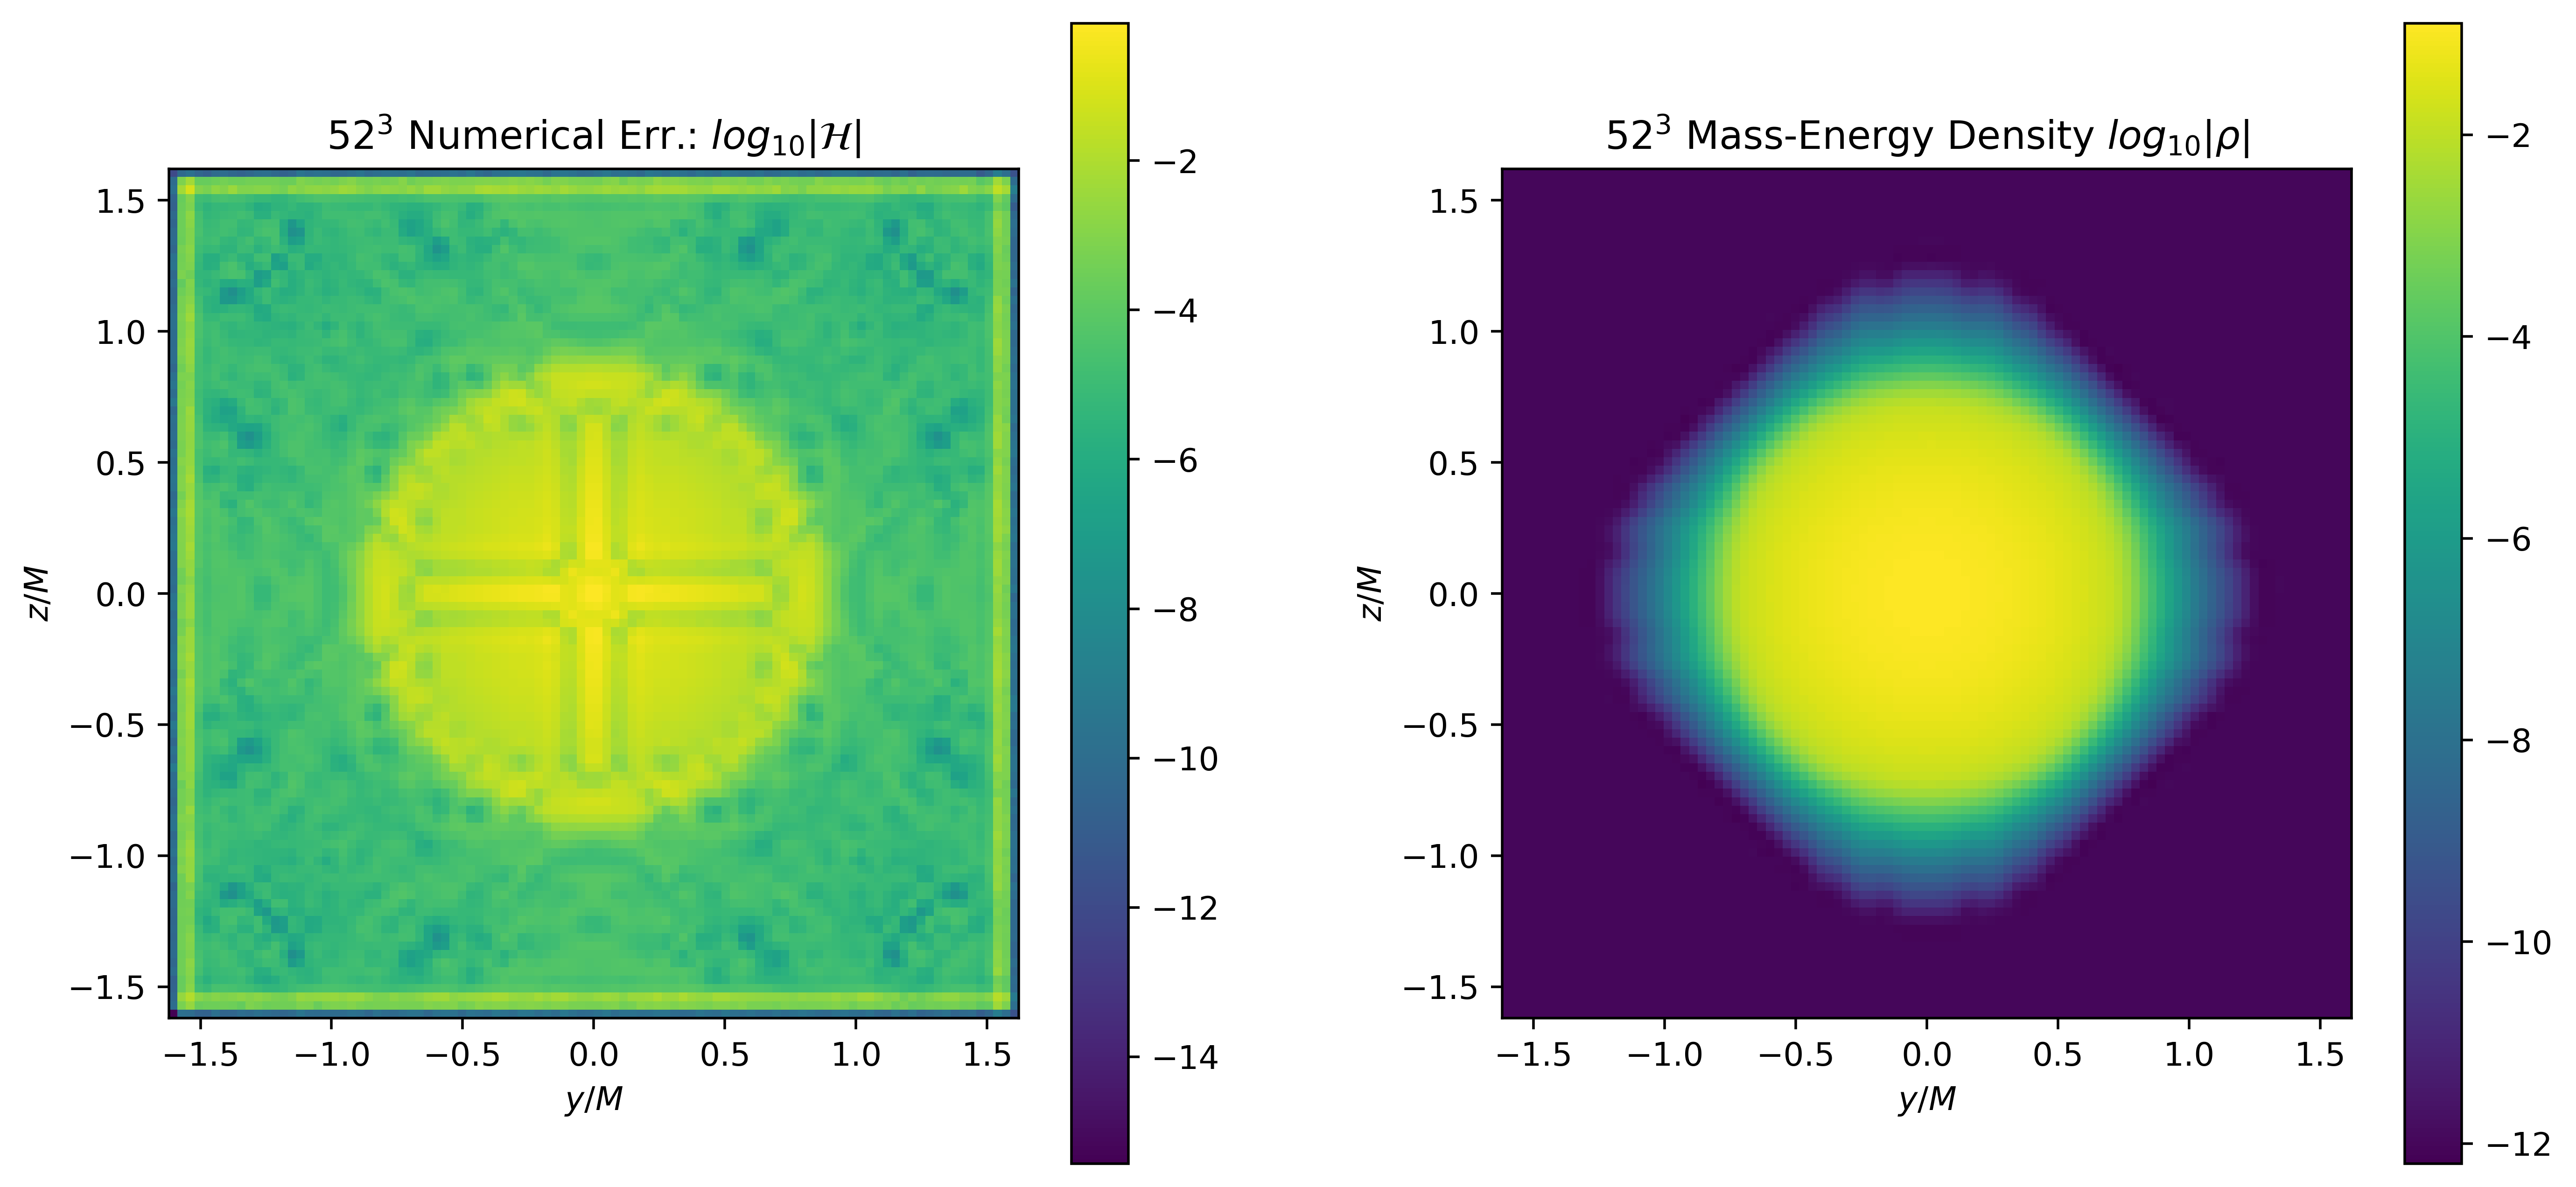

In [33]:
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
from IPython.display import Image

xy_extent=domain_size
# Data are in format x,y,z, CF,Ham,rho
output_grid_x, output_grid_y, output_grid_data_Ham = \
    plot2D.generate_uniform_2D_grid(os.path.join("output",'out52.txt'), 1,2,4, [-xy_extent,xy_extent], [-xy_extent,xy_extent])
# Ham data are in column 4 --------------------------^
output_grid_x, output_grid_y, output_grid_data_rho = \
    plot2D.generate_uniform_2D_grid(os.path.join("output",'out52.txt'), 1,2,5, [-xy_extent,xy_extent], [-xy_extent,xy_extent])
# rho data are in column 5 --------------------------^

output_grid_data = []
output_grid_data += [output_grid_data_Ham]
output_grid_data += [output_grid_data_rho]

fig = plt.figure(figsize=(12, 6))

axN = []  # initialize axis/plot array.


Labels = [r"$52^3$ Numerical Err.: $log_{10}|\mathcal{H}|$",
          r"$52^3$ Mass-Energy Density $log_{10}|\rho|$"]

for whichplot in range(2):
    #Generate the subplot for the each constraint
    ax = fig.add_subplot(121 + whichplot)
    axN.append(ax) # Grid of 2x1

    axN[whichplot].set_xlabel(r'$y/M$')
    axN[whichplot].set_ylabel(r'$z/M$')
    axN[whichplot].set_title(Labels[whichplot])

    figure = plt.imshow(output_grid_data[whichplot], extent=(-xy_extent,xy_extent, -xy_extent,xy_extent))
    cb = plt.colorbar(figure)

# Adjust the spacing between plots
plt.tight_layout(pad=4)

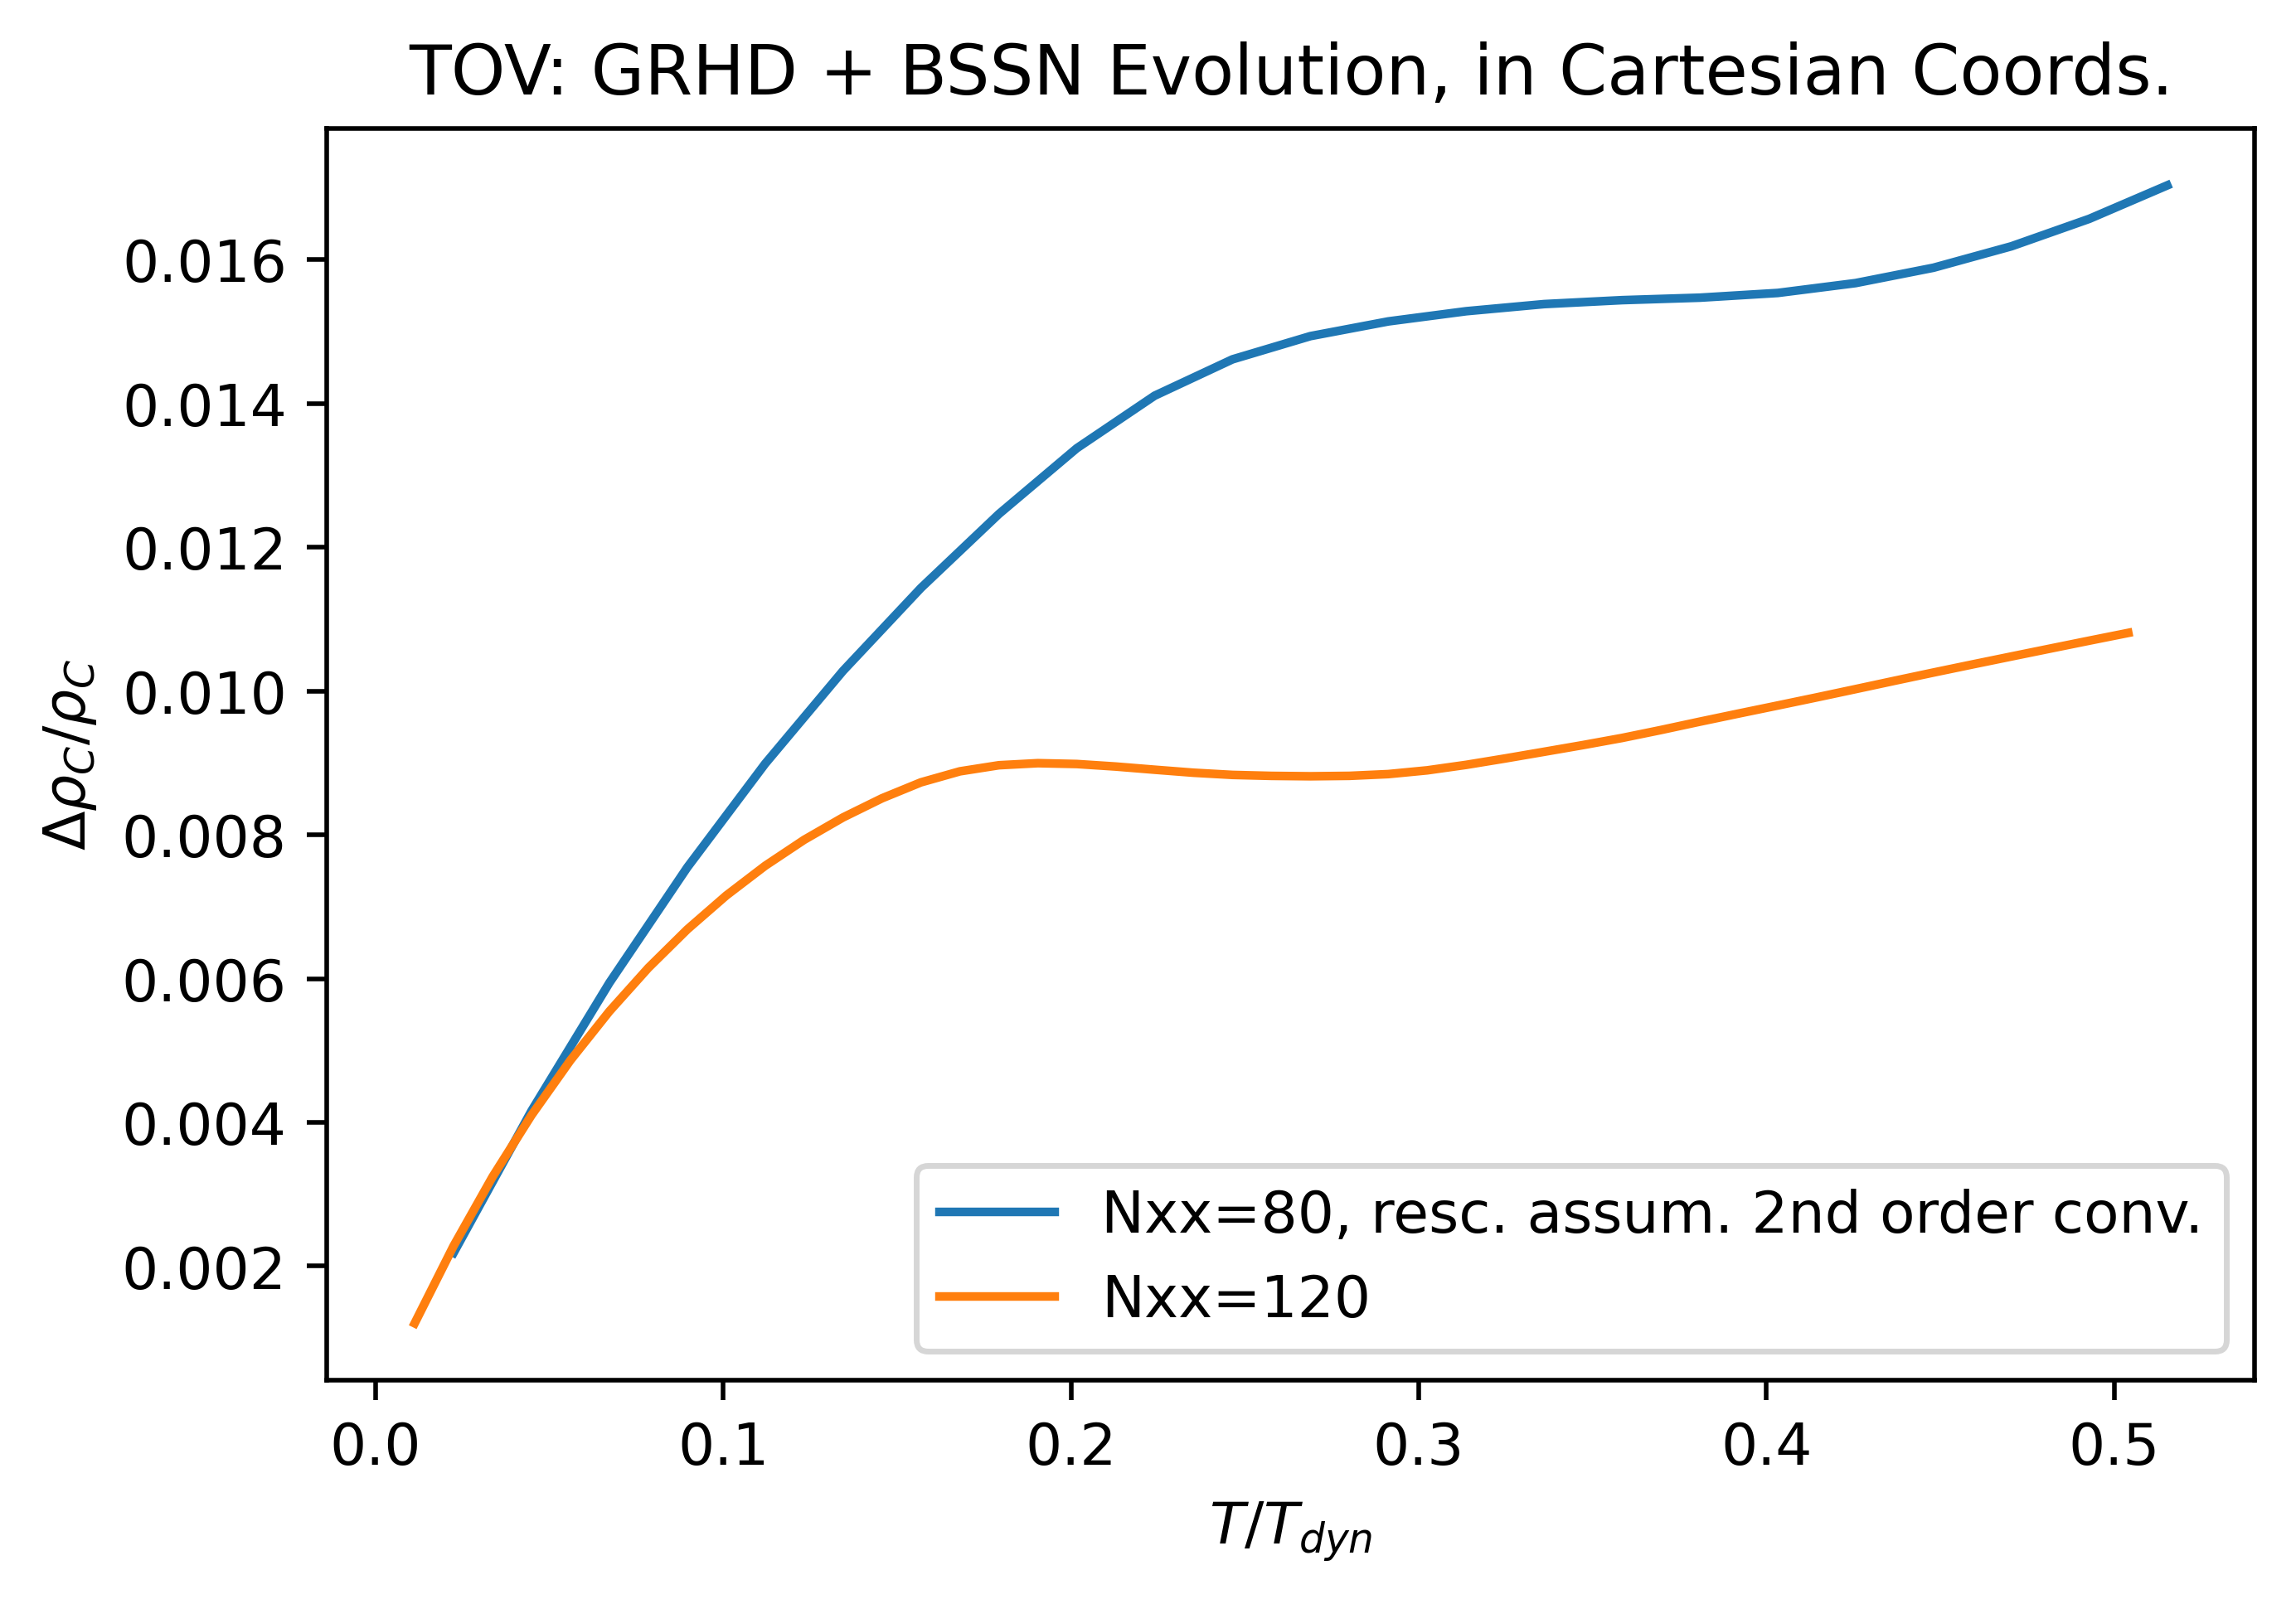

In [32]:
T_dyn = (1./(np.sqrt(rho_baryon_central)))

idx = -2

raw_data_low = np.loadtxt(os.path.join("output","out_density32.txt"))
plt.plot(raw_data_low[1:,0]/T_dyn, 
 ((80./120.)**2.)*(np.abs(raw_data_low[0, idx] - raw_data_low[1:, idx])/raw_data_low[0, idx]),
        label='Nxx=80, resc. assum. 2nd order conv.')

raw_data = np.loadtxt(os.path.join("output", "out_density58.txt"))
plt.plot(raw_data[1:,0]/T_dyn, np.abs(raw_data[0, idx] - raw_data[1:, idx])/raw_data[0, idx],
        label='Nxx=120')

plt.xlabel(r"$T/T_{dyn}$")
plt.ylabel(r"$\Delta\rho_C / \rho_C$")
plt.legend()

plt.title("TOV: GRHD + BSSN Evolution, in Cartesian Coords.")
plt.show()

<a id='latex_pdf_output'></a>

# Step 5: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-ScalarWaveCurvilinear.pdf](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [ ]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-ScalarWaveCurvilinear")